# Droplets

This *jupyter* notebook carries out the analyses in the upcoming journal article focusing on analyzing gravitationally unbound, coherent structures with significant velocity gradients.  The notebook is edited to work with data and *Python* scripts in the [Github repo](https://github.com/hopehhchen/Droplets).

## 0. Abstract and Outlines

The project looks for coherent cores with significant velocity gradients in the L1688 region in Ophiuchus and the B18 region in Taurus, out of the four nearby star forming regions covered by the *GBT Ammonia Survey* (GAS) Data Release 1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)).  One goal of the project is to update numbers for physical properties of (potentially) rotational motions within these structures.  The relation between the velocity gradient and the size was first examined using observations of ammonia molecular line emission by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  With an improved physical resolution of ~4000 AU (the FWHM beam size at the distance of Ophiuchus and Taurus), we hope to provide more reliable and relevant numbers for simulations and analytical models, especially ones concerning with disk formation inside star forming cores.

Subsequent analyses included in this project discover that the structures are possibly gravitationally unbound, despite subsonic velocity dispersions and relatively high column densities.  The behavior is unexpected in the final stages of monolithic star formation driven by gravity.  Due to their small sizes and the seeming unboundness, we term these structures "droplets," to distinguish them from "cores," which are often used to indicate bound and star forming, sub-parsec structures.  The project aims at providing a guess to how the "droplets" are formed and what role they could play in the star formation process.

This notebook is organized as follows. In [***I. Identification of Structures***](#identification), we go through how we identify these structures and how we define the boundaries.  In [***II. Physical Properties of Droplets***](#properties), we derive the basic physical properties of the "droplets," based on the property maps from ammonia line fitting to the GAS DR1 data.  In ***III. Kinematics and Dynamics***, we look for possible explanations to the formation of "droplets" and the role they play in star formation.  In particular, we look into the spatial distribution of ram pressure within and around the "droplets," to see whether the droplets could be pressure-bound.  In all sections of this notebook, we also provide the codes to generate tables and plots that eventually appear in the corresponding parts of the article.

Further discussions are included in the article hosted on Authorea.  **This notebook, though filled with definitions essential for users to understand the analyses, is *not* meant to be complete or continuous as the journal article itself.**  Please look in the article for details.

***CAUTION: This is work in progress.***

[*The square brackets in this notebook host the technical explanations of following code cells.  They should be treated as code comments.*]

#### Authors
* **Hope Chen** (leading and corresponding, at <hhchen@cfa.harvard.edu>; Harvard-Smithsonian Center for Astrophysics)
* Jaime Pineda (Max-Planck-Institut für Extraterrestrische Physik)
* Alyssa Goodman (Harvard-Smithsonian Center for Astrophysics)
* Andreas Burkert (University Observatory Munich)

#### Code Dependencies
The version numbers listed below correspond to the versions used when this notebook is compiled.  Most *Python* packages are backward compatible, but there is no guarantee.  Please report problems via [the issue tracker of the Droplet repo](https://github.com/hopehhchen/Droplets/issues).
* `numpy`: v1.13.1
* `scipy`: v0.19.1
* `astropy`: v2.0.2
* `FITS_tools`: v0.0.dev
* `matplotlib`: v2.0.2
* `pandas`: v0.20.3

In [1]:
%matplotlib inline
import sys
import os
from collections import *

#
import numpy as np
import scipy

#
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
import astropy.constants as c
import FITS_tools as fits_tools

#
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#from matplotlib import rcParams

#
import pandas as pd

## 
from Droplets import *
from constants import *
import styles

#### Main Variables in this Notebook
The variables are derived along the way following the steps outlined above.  This list is just for bookkeeping.  (The attached link goes to the code cell where each variable is first defined.)
* [`dict_data`](#dict_data): The *Python* dictionary that stores the maps in "`./data/`".  The data are from the GAS DR1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)), with the original files stored in [this dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project).
* [`dict_masks`](#dict_masks): The *Python* dictionary that stores the masks for the target structures in "`./results/masks/`".
* [`dict_YSOs`](#dict_YSOs): The *Python* dictionary that sotres the YSO catalogs in "`./data/YSO_catalogs/`".  The catalogs are originally from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract), and include only Class 0/I and flat spectrum YSOs above certain "grades" assigned in the original works.  The original catalogs can be found on VizieR: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).
* [`dict_Vlsr_predicted`](#dict_Vlsr_predicted): The *Python* dictionary that stores the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits, in "`./results/Vlsr_predicted/`".  Details about fitting of $V_\text{LSR}$ can be found in [***II. Physical Properties of Droplets***](#properties).

<a id='data'></a>
### 0.1 Data and Targets

The GAS DR1 inlcudes observations of the ammonia hyperfine line emission made with the *Green Bank Telescope* (GBT).  By fitting Guassian profiles to the ammonia hyperfine lines, [Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) derive the property maps of four nearby star forming regions: B18 in Taurus, L1688 in Ophiuchus, NGC1333 in Perseus, and Orion A North.  These physical properties include the NH$_3$ velocity centroid (in the LSR frame; $V_\text{LSR}$), the NH$_3$ velocity dispersion ($\sigma_V$), the NH$_3$ column density ($N_{\text{NH}_3}$), the excitation temperature of NH$_3$ hyperfine lines ($T_\text{ex}$), and the kinetic temperature ($T_\text{kin}$).  Besides property maps included as part of the GAS DR1, we also derive the peak main beam temperature from the trimmed and baseline subtracted data cubes from observations of NH$_3$ (1, 1) hyperfine lines.  We look for coherent structures using these physical properties in the B18 region and the L1688 region, where their proximity (at the distances of ~135 and ~137.3 pc, respectively; [Schlafly et al., 2014](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract); [Ortiz-León et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract)) grants us the highest physical resolution (the GBT FWHM beamsize of 32" at 23 GHz corresponds to ~4300 AU).

[*The Python dictionary `distances` stores the distances that are used throughout this paper, in the formats of `astropy.units`.  The code cell below is for demonstrative purpose; for a complete list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [2]:
distances = {'L1688': 137.3*u.pc, 'B18': 135.*u.pc}
## uncertainties
distances['L1688_e'] = 6.*u.pc
distances['B18_e'] = 20.*u.pc

The GAS data are supplemented by the column density and dust temprature maps derived using *Herschel* observations of dust continuum emission.  The *Herschel* observations were made as part of the *Herschel Gould Belt Survey* (GBS; [André et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010A&A...518L.102A/abstract)), and the data are from the *Herschel* Science Archive.  Ayushi Singh and Peter Martin at University of Toronto derived maps of the optical depth and the dust temperature by fitting the SED from the SPIRE observations to opaticy corrected blackbody emission ("gray-body emission"; [Hildebrand, 1983](https://ui.adsabs.harvard.edu/#abs/1983QJRAS..24..267H/abstract)).  Singh and Martin assumed a dust opacity at 1 THz ($\kappa_\text{1THz}$) of 10 cm$^2$ g$^{-1}$ with a power-law dependence on the frequency to the order of $\beta = 1.62$, and also a gas to dust ratio of 100.  The resulting maps can be found in the [github `./data/Herschel/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/Herschel), with key parameters used in the SED fitting accessible in the FITS headers.  The FWHM beamsize of SPIRE 500 µm is 36", which matches well with the GBT beamsize.

The full GAS DR1 dataset is hosted on [Dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), which includes the original data cubes from GBT observations of various molecular lines.  The peak main beam temperature maps were not included in the set of property maps in the GAS DR1, but were instead derived from the trimmed and baseline subtracted data cubes.  Due to the github policy for large data files, the  [Droplets github repo](https://github.com/hopehhchen/Droplets) includes only the data maps that are needed in the analyses, but not the data cubes from which the property maps were derived.

[*The datasets are read and stored in `dict_data`.  The maps of error in each phsyical property were produced for the GAS DR1 alongside the property maps, and are stored in `dict_data` with a prefix "`e`".  The property maps in the GAS DR1 are flagged by the detection level and the goodness of the fit.  In the array directly read in from files in [this github repo](https://github.com/hopehhchen/Droplets) and in the [GAS DR1 dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), the flagged pixels within the observed areas have values of 0.  In the following code cell, we remove the flags by converting them to NaN values, for the ease of future calculation.  This is not done for the maps of the peak main beam temperature, which is derived from the data cubes that include the full observed areas.*]
<a id='dict_data'></a>

In [3]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'
## lists of property maps to be read in
list_propertiesGAS = ['Vlsr', 'Sigma', 'N_NH3', 'Tex', 'Tkin']
list_propertiesHerschel = ['colden', 'temp']


# Read the data.
dict_data = {'L1688': {}, 'B18': {}}
for reg in ['L1688', 'B18']:
    
    # GAS DR1 Property Maps
    for prop in list_propertiesGAS:
        ## data
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg][prop] = data
        
        ## error maps
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_e'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg]['e'+prop] = data
    ## header
    dict_data[reg]['header_GAS'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Vlsr_DR1_rebase3_flag.fits')[0].header
    
    # GAS DR1 Peak Main Beam Temperature
    dict_data[reg]['Tpeak'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Tpeak_DR1_rebase3_trim.fits')[0].data
    
    # Herschel
    for prop in list_propertiesHerschel:
        ## data
        dict_data[reg][prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_masked.fits')[0].data
        
        ## error maps
        dict_data[reg]['e'+prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_err_masked.fits')[0].data
    ## header
    dict_data[reg]['header_Herschel'] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_colden_masked.fits')[0].header

Several properties that are immediately derivable from the property maps include the total velocity dispersion ($\sigma_\text{tot}$) and its thermal and non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$, respectively).  These can be derived from the NH$_3$ linewidth ($\sigma_{\text{NH}_3}$) and the kinetic temperature of the gas ($T_\text{kin}$), assuming that different species of molecules are at a thermal equilibrium.  The equation used here is: <a id='eq-Sigma'></a>$$\sigma_\text{tot}^2 = \sigma_{\text{NH}_3}^2 - \frac{k_B T_\text{kin}}{m_{\text{NH}_3}} + \frac{k_B T_\text{kin}}{m_\text{ave}} \text{,}\ \ \ \ \ \text{[1]}$$ where $m_{\text{NH}_3}$ is the molecular weight of NH$_3$ and $m_\text{ave}$ is the average particle weight.  Throughout this paper, we use $m_\text{ave} = 2.37\ \text{a.m.u.}$ based on the results presented by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract), and $m_{\text{NH}_3} = 17.031\ \text{a.m.u.}$ according to the [IUPAC value](https://pubchem.ncbi.nlm.nih.gov/compound/ammonia#section=Top).

The total velocity dispersion can be further separated into the thermal and the non-thermal components.  The thermal component of the velocity dispersion is the velocity dispersion expected of an average particle ($m_\text{ave} = 2.37\ \text{a.m.u.}$) at the kinetic temperature, $T_\text{kin}$.  That is, <a id='eq-SigmaT'></a>$$\sigma_\text{T}=\sqrt{\frac{k_\text{B}T_\text{kin}}{m_\text{ave}}}\ \text{.}\ \ \ \ \ \text{[2]}$$  This is also the sound speed of a uniform medium composed of the average particles, at $T_\text{kin}$.  The non-thermal component of the velocity dispersion is the NH$_3$ linewidth beyond what can be explained by the thermal velocity dispersion of the NH$_3$ particles.  That is, <a id='eq-SigmaNT'></a>$$\sigma_\text{NT}=\sqrt{\sigma_{\text{NH}_3}^2-\frac{k_\text{B}T_\text{kin}}{m_{\text{NH}_3}}}\ \text{.}\ \ \ \ \ \text{[3]}$$  The thermal and the non-thermal components are related to the total velocity dispersion by a squared sum: <a id='eq-SigmaSum'></a>$$\sigma_\text{tot}^2 = \sigma_\text{T}^2+\sigma_\text{NT}^2\ \text{.}\ \ \ \ \ \text{[4]}$$

[*The derived properties: $\sigma_\text{tot}$, $\sigma_\text{T}$, and $\sigma_\text{NT}$ are stored in the same dictionary: `dict_data`.  The following code cell might generate a `RuntimeWarning` regarding invalid value encoutered in sqrt, which by default would simply produce a NaN value at the pixel(s).  The warning message is due to the unlikely event where the observed NH$_3$ linewidth is narrower than the thermal linewidth of the NH$_3$ molecules expected at the observed kinetic temperature.  This happens only at ~0.01% of the sky areas observed in the L1688 and B18 regions combined.  The definition of the variable `mass` below is merely for demonstrative purpose.  For the full list of constants used in this paper, see [`constants.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/constants.py).*]

In [4]:
# mass for the NH3 molecule and an average particle in ISM
mass = {'NH3': 17.031*u.u, 'average': 2.37*u.u}


# Derive the total velocity dispersion, and its thermal and non-thermal components.
for reg in ['L1688', 'B18']:
    
    # NH3 linewidth and kinetic temperature from GAS DR1
    sigmaNH3 = dict_data[reg]['Sigma']
    Tkin = dict_data[reg]['Tkin']
    
    
    # derived properties
    ## thermal and non-thermal components
    sigmaNT = np.sqrt((sigmaNH3*u.km/u.s)**2. - c.k_B*Tkin*u.K/mass['NH3']).to(u.km/u.s).value
    sigmaT = np.sqrt(c.k_B*Tkin*u.K/mass['average']).to(u.km/u.s).value
    ## total velocity dispersion
    sigmaTot = np.sqrt((sigmaNT*u.km/u.s)**2.+(sigmaT*u.km/u.s)**2.).to(u.km/u.s).value
    
    
    # store the derived maps
    dict_data[reg]['SigmaNT'] = sigmaNT
    dict_data[reg]['SigmaT'] = sigmaT
    dict_data[reg]['SigmaTot'] = sigmaTot

//anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in sqrt
  *arrays, **kwargs)


For easier comparison between the GAS DR1 data and the *Herschel* maps, we project the *Herschel* maps to the GAS DR1 grid.  As mentioned above, the GBT has a FWHM beamsize at 23 GHz (32") similar to the FWHM beamsize of *Herschel* 500 µm (36").  Thus, we can safely assume that the regridding does not introduce a significant biase.

[*The regridding is done using the *Python* package [`FITS_tools`](http://fits-tools.readthedocs.io/en/latest/fits_tools.html).  The newly projected images replace the original images in `dict_data`.*]

In [5]:
# Regrid the Herschel maps.
for reg in ['L1688', 'B18']:
    
    for prop in list_propertiesHerschel:
        
        # Regrid using hcongrid.
        ## data
        image = dict_data[reg][prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg][prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)
        
        ## error maps
        image = dict_data[reg]['e'+prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg]['e'+prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)

In the analyses below, we use YSO catalogs from [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) and [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract) to determine the existence of YSO sources potentially associated with target structures in Ophiuchus and in Taurus, respectively.  Parsed versions of the catalogs that include only Class 0/I and flat spectrum YSOs, above certain "grades" of reliability assigned in the papers just mentioned, can be found in [the data folder of this github repo](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/YSO_catalogs).  The original, full catalogs can be found on [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR) on the corresponding catalog pages: [catalogs in Dunham et al. (2015)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/220/11) and [catalogs in Rebull et al. (2010)](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/186/259).

The parsed versions of the catalogs include only Class 0/I and flat spectrum YSOs (according to the definitions in the corresponding papers mentioned above), which are not AGBs in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract) nor below the rank "A-" in [Rebull et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract).  There is information about the coordinates, the object names in the original surveys, and the classification in the catalogs.  In the case of [`L1688.csv`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/YSO_catalogs/L1688.csv), the column "`alpha_prime`" corresponds to the extinction corrected spectral index, $\alpha^\prime$, in [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), and is used to determine the class of the YSOs.  According to [Dunham et al. (2015)](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract), YSOs with $\alpha^\prime \geq 0.3$ belong to Class 0/I, and YSOs with $0.3 > \alpha^\prime \geq -0.3$ belong to the "flat spectrum" category.

[*Since only the pixel coordinates on the GAS data projection are needed, the celetial coordinates are converted using the GAS headers before being stored in `dict_YSOs`.  The resulting array of pixel coordinates has a length of the number of YSOs in the catalog and a width of two corresponding to the x (Axis 1 in a numpy array) and the y (Axis 0 in a numpy array) coordinates.*]
<a id='dict_YSOs'></a>

In [6]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'

# Read the data.
dict_YSOs = {}
for reg in ['L1688', 'B18']:
    
    ## catalogs
    catalog = pd.read_csv(direcData+'YSO_catalogs/'+reg+'.csv')
    
    ## header used for converting YSO coordinates to pixel coordinates
    header = dict_data[reg]['header_GAS']
    
    ## Convert YSO coordinates to pixel coordinates
    projection = wcs.WCS(header)
    dict_YSOs[reg] = projection.wcs_world2pix(np.c_[catalog['RA'].values, catalog['Dec'].values], 0)

### 0.2 Sources from [*Goodman et al. (1993)*](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract)

[Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) presented a survey of 43 sources with observations of NH$_3$ line emission (see the [SIMBAD obejct list](http://simbad.harvard.edu/simbad/sim-ref?querymethod=bib&simbo=on&submit=submit+bibcode&bibcode=1993ApJ...406..528G); several objects are associated with different SIMBAD identifiers than in the paper).  The properties of the sources are summarized in Table 1 and Table 2 of the paper.  Unfortunately, no digitization exists for the paper and the tables, so we manually duplicate the two tables, and the results can be found in the [github `./data/Goodman93/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/Goodman93).

To compare the properties of the 43 sources observed by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), we update the tables with 1) peak positions in the FK5 J2000.0 frame, 2) updated mass of average particles (2.37 a.m.u.; [Kauffmann et al., 2008](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract)), 3) updated measurements of distances, and 4) updated derived properties based on the new particle weight and distances.  The updated distances are summarized below:

1. Regions associated with the molecular cloud in Perseus: **PER3**, **PER6**, and **B5**.  We adopt distances measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract) using *PanSTARRS-1* photometry, which are 315±32 pc for the western part of the Perseus molecular cloud (including PER3 and PER6) and 260±26 pc for the eastern part (including B5).

2. Regions associated with the molecular cloud in Taurus: **L1489**, **L1498**, **L1495**, **L1495NW**, **L1495SE**, **TAU11**, **TAU16**, **B217**, **L1524**, **TMC-2A**, **L1534** (TMC-1A), **L1527**, **TMC-1C**, and **L1517B**.  We adopt a distance of 135±20 pc, measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

3. Regions associated with $\lambda$ Orionis: **L1582A** and **B35A**.  We adopt a distance of 420±42 pc, measured by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

4. A region associated with the molecular cloud and the YSO cluster in Ophiuchus (sometimes under the name of $\rho$ Oph): **L1696A**.  We adopt a distance of 137.3±6 pc, measured by [Ortiz-León et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract) using parallax.

5. Regions associated with clouds and clumps in Oph N: **L43/RNO90**, **L43**, **L260** (a.k.a. L255), **L158**, **L234E**, **L234A**, and **L63**.  These regions are usually associated with the Ophiuchus complex or, on a larger scope, the Upper Sco-Oph-Cen complex.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) adopted the same distance for these regions as for L1696A.  Here we use an updated distance measurement of 125±18 pc to the Ophiuchus complex by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).  This is in good agreement with the widely used 125±45 pc, measured by [de Geus et al. (1989)](https://ui.adsabs.harvard.edu/#abs/1989A&A...216...44D/abstract).

6. Regions associated with Cepheus Flare: The Cepheus Flare spans more than 10 degrees from North to South on the plane of the sky, and is known to have a complicated structure with multiple concentrations of material at different distances.  Here we adopt distance measurements for different regions in Cepheus Flare, and note that these distances were used by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/?#abs/2008A%26A...487..993K) side-by-side.  Note, however, that [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract) measured 360±35 pc for the southern part of Cepheus Flare and 900±90 pc for the northern part of Cepheus Flare.  See discussions in [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).

    a. **L1152**: 325±13 pc, measured by [Straižys et al. (1992)](https://ui.adsabs.harvard.edu/?#abs/1992BaltA...1..149S/abstract) using photometry.
    
    b. **L1082C**, **L1082A**, and **L1082B**: 400±50 pc, measured by [Bourke et al. (1995)](https://ui.adsabs.harvard.edu/?#abs/1995MNRAS.276.1052B/abstract) using photometry.
    
    c. **L1174** and **L1172A**: 288±25 pc, measured by [Straižys et al. (1992)](https://ui.adsabs.harvard.edu/?#abs/1992BaltA...1..149S/abstract) using photometry.
    
    c. **L1251A**, **L1251E**, and **L1262A**: we update the distance used by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/?#abs/2008A%26A...487..993K) based on [Kun (1998; 300$^{+50}_{-10}$ pc)](https://ui.adsabs.harvard.edu/?#abs/1998ApJS..115...59K/abstract) with a more recent measurement of 286±20 pc made by [Zdanavičius et al. (2011)](https://ui.adsabs.harvard.edu/#abs/2011BaltA..20..317Z/abstract) using photometry.
    
7. Other regions with distances measured from masers:

    a. **L1400G** and **L1400K**: 170±50 pc, measured by [Montillaud et al. (2015)](https://ui.adsabs.harvard.edu/?#abs/2015A%26A...584A..92M).
    
    b. **L134A**: 110±10 pc, measured by [Montillaud et al. (2015)](https://ui.adsabs.harvard.edu/?#abs/2015A%26A...584A..92M).
    
8. Regions of which the distances are not updated since 1990s, but are cited recently.  Here we provide a list of the original references and the most recent year when each reference was cited.

    a. **L483**: 200 pc [(Dame & Thaddeus, 1985)](https://ui.adsabs.harvard.edu/#abs/1985ApJ...297..751D/abstract), with citations as recent as 2017.
    
    b. **L778**: 200 pc [(Schneider & Elmegreen, 1979)](https://ui.adsabs.harvard.edu/#abs/1979ApJS...41...87S/abstract), with citations as recent as 2017.
    
    c. **B361**: 350 pc [(Schmidt, 1975)](https://ui.adsabs.harvard.edu/?#abs/1975MNRAS.172..401S/abstract), with citations as recent as 2010.
    
    d. **L1031B**: 900 pc [(Hilton and lahulla, 1995)](https://ui.adsabs.harvard.edu/#abs/1995A&AS..113..325H/abstract), with citations as recent as 2017.
    
And the derived properties are affected by the updates in distance:

1. Mass ($M$): Since the mass was calculated from the number density derived by modeling the radiative transfer of NH$_3$ line emission, the mass estimates scale with the distance to the cubic order, $M \propto D^3$.

2. Sizes ($r_\text{major}$, $r_\text{minor}$, and $R$): Sizes $\propto D$.

3. The velocity gradient ($\mathcal{G}$): $\mathcal{G} \propto D^{-1}$.

4. The product of the gradient and the radius ($\mathcal{G}\times R$): The product remains unchanged, since the effect of a new distance cancels out.

5. The ratio of rotational and gravitational energies ($\beta$): $\beta \propto \mathcal{G}^2 \propto D^{-2}$.

6. The specific angular momentum ($J/M$): $J/M \propto \mathcal{G}R^2 \propto D$.

Based on these updates, we also create new columns including information on the uncertainties in the distance measurements and the radii used by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) in subsequent calculations, which are the geometric means of the FWHMs along the major and minor axes ($r_\text{major}$ and $r_\text{minor}$): <a id='eq-Reff'></a>$$R_\text{eff} = \sqrt{r_\text{major}\times r_\text{minor}}\ \ \text{.}\ \ \ \ \ \text{[5]}$$

Unfortunately, the change due to an updated average particle weight cannot be applied on the total velocity dispersion, since no values of $T_\text{kin}$ and $\sigma_{\text{NH}_3}$ used in calculations of $\sigma_\text{tot}$ were given by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), except pointers to the work done by [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract), Ladd 1991 (thesis work), and private communication with Benson in 1992.  We include peer reviewed values in [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) and the published numbers in [Ladd et al. (1994)](https://ui.adsabs.harvard.edu/#abs/1994ApJ...433..117L/abstract), which is based on Ladd 1991, in the updated table (Column "`Tkin`" and Column "`SigmaNH3`" in [`table1_updated.csv`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/Goodman93/table1_updated.csv)), even though calculating $\sigma_\text{tot}$ based on these numbers usually result in disagreement with the numbers presented by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), with discrepancy up to 7%.  The values reported via private communication with Benson were not made publicly available (covering a total of 5 regions out of the 43 regions presented by [Goodman et al., 1993](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract)).  Since for typical values of $\sigma_{\text{NH}_3}$ and $T_\text{kin}$, the change of average particle weight from 2.33 a.m.u. to 2.37 a.m.u. [(Kauffmann et al., 2008)](https://ui.adsabs.harvard.edu/?#abs/2008A%26A...487..993K) usually affects $\sigma_\text{tot}$ by less than 1%, we do not update measurements of $\sigma_\text{tot}$ presented by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) with the updated average particle weight.  See [Figure Extra 1](#fig-examineTable1Sigmas) for a visualization of comparison.

[*The following code cell runs the codes used to update Table 1 and Table 2 from [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), and the static versions are saved in the [github `./data/Goodman93/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/Goodman93).  The codes used to covert and update Table 1 and Table 2 in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) are wrapped in [`./Goodman93_updates.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Goodman93_updates.py).  Note that values in original Table 1 and Table 2 are rounded to the nearest significant digits.  No rounding is done, however, for the updated values below.  This is to guarantee a continuous and consistent conversion over all data points when compared to the properties derived in this paper.  Please use the original tables to find the significant digits when needed.  The updated tables are read in using the `pandas` package.*]

In [7]:
# Update and convert values in the original tables.
import Goodman93_updates

# Read the updated tables.
direcData = os.getcwd()+'/data/Goodman93/'
dict_tables = {}
dict_tables['Goodman93_table1'] = pd.read_csv(direcData+'table1_updated.csv',
                                              index_col = False)
dict_tables['Goodman93_table2'] = pd.read_csv(direcData+'table2_updated.csv',
                                              index_col = False)

In [Figure Extra 1](#fig-examineTable1Sigmas), $\sigma_\text{tot}$ presented in [Table 1](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/Goodman93/table1_updated.csv) in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) is compared to values calculated from $T_\text{kin}$ and $\sigma_{\text{NH}_3}$ in [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) and [Ladd et al. (1994)](https://ui.adsabs.harvard.edu/#abs/1994ApJ...433..117L/abstract), assuming $m_\text{ave}$ of 2.33 or 2.37 a.m.u.  In a total of 12 regions (**B5**, **L1495-NW**, **L1400G**, **B217**, **L1524**, **TMC-2A**, **L234E**, **L63**, **L1152**, **L1174**, **B361**, and **L1251A**), the difference due to different assumptions of the average particle weight is visibly smaller than the difference between $\sigma_\text{tot}$ from [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) and values calculated from $T_\text{kin}$ and $\sigma_{\text{NH}_3}$ in [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) and [Ladd et al. (1994)](https://ui.adsabs.harvard.edu/#abs/1994ApJ...433..117L/abstract).  In another 7 regions (**L1495**, **L1495-SE**, **TAU11**, **TAU16**, **L43/RNO90**, **L483**, and **L1251E**), either [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) and [Ladd et al. (1994)](https://ui.adsabs.harvard.edu/#abs/1994ApJ...433..117L/abstract) provided no estimates of $T_\text{kin}$ or $\sigma_{\text{NH}_3}$ (L1495 and L1495-SE), or that the data obtained via private communication with Benson by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) were never published.  The discrepancies and the lack of data occur in 19 regions (out of the 43 regions in Table 1 in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract)), and have made updates using the new average particle weight impractical.

[**Figure Extra 1.**](#fig-examineTable1Sigmas)<a id='fig-examineTable1Sigmas'></a> **The plot shows the difference between $\sigma_\text{tot}$ presented in [Table 1](https://github.com/hopehhchen/Droplets/blob/master/Droplets/data/Goodman93/table1_updated.csv) and the values calculated from $T_\text{kin}$ and $\sigma_{\text{NH}_3}$ in [Benson and Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) and [Ladd et al. (1994)](https://ui.adsabs.harvard.edu/#abs/1994ApJ...433..117L/abstract), assuming $m_\text{ave}$ of 2.33 or 2.37 a.m.u. (see [Eq. 1](#eq-Sigma)).**  The region names are labeled on the x-axis.  [***This plot is not included in the article (thus the name).  Change `plotNewWeight` to plot/un-plot estimates of $\sigma_\text{tot}$ using $m_\text{ave} = 2.37\ \text{a.m.u.}$***]

[*The codes used to produce the following plot are wrapped in the `plotTable1Sigmas` function, in [`./Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

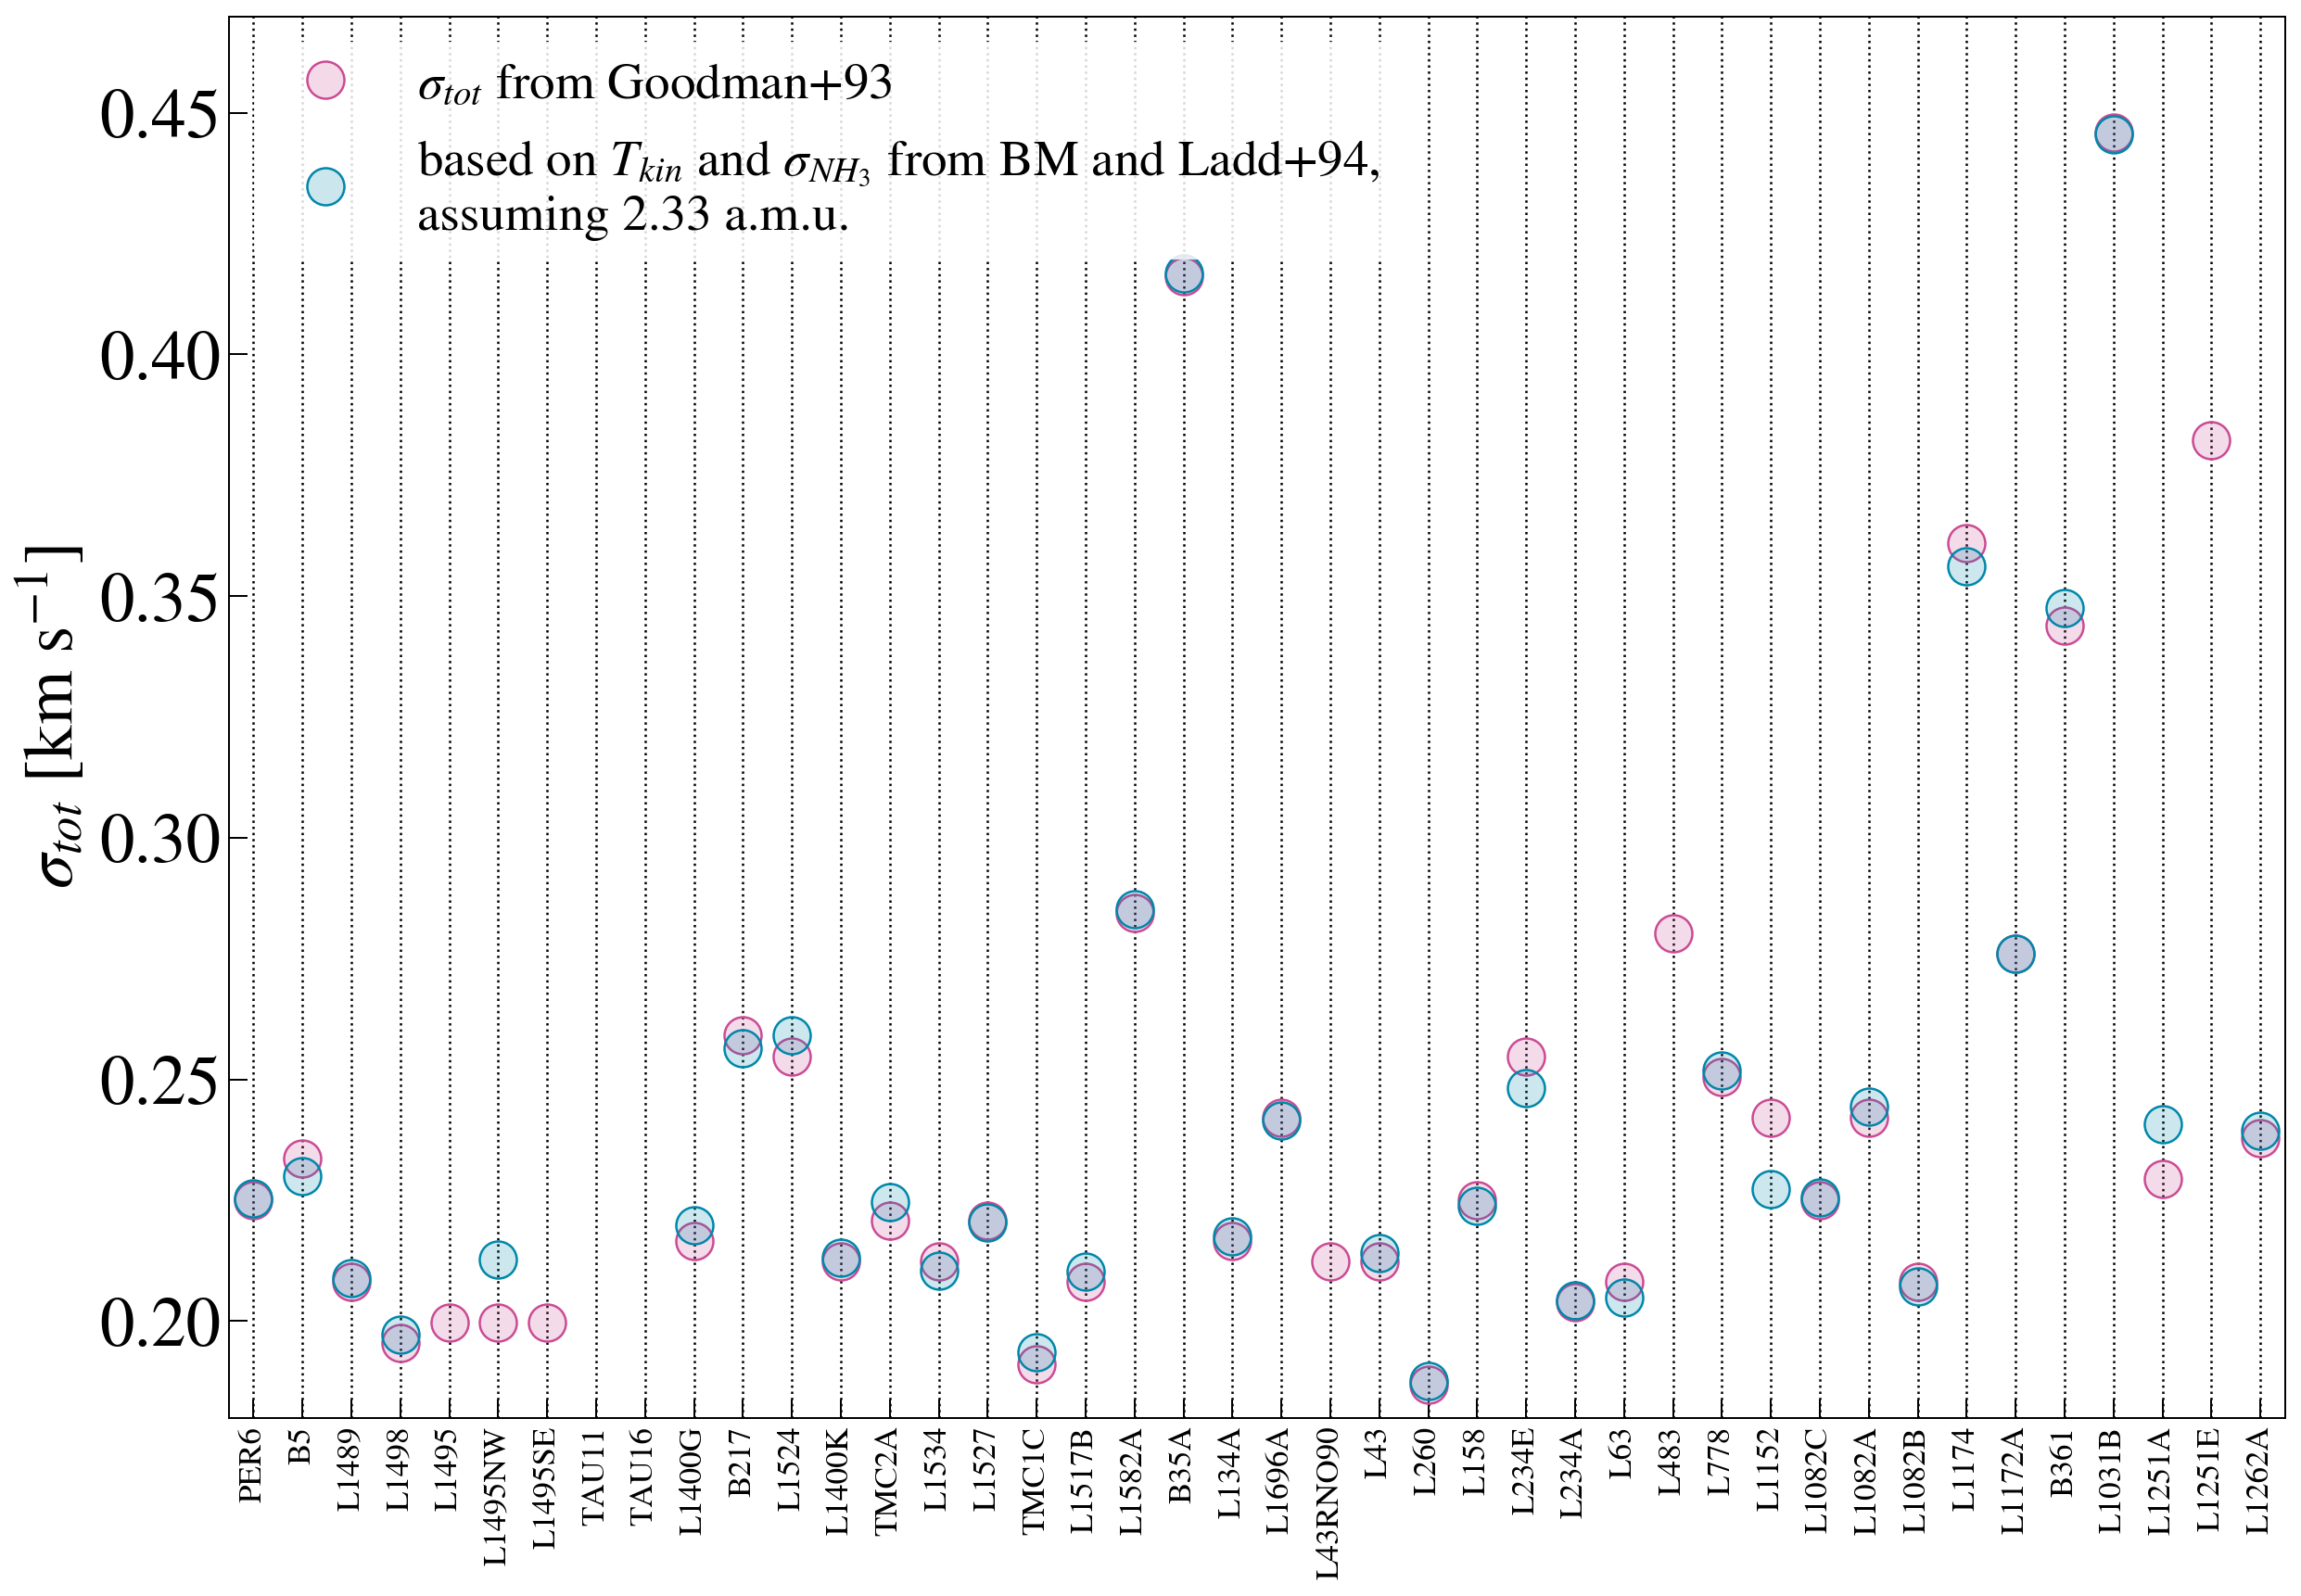

In [14]:
table = dict_tables['Goodman93_table1']
fig = plotTable1Sigmas(table, plotNewWeight = False)  ## <<< Change the code in this line!

<a id='identification'></a>
## I. Identification of Structures

We look for coherent structures ([Goodman et al., 1998](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract)) in the L1688 region in Ophiuchus and the B18 region in Taurus.  [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract) proposed that these coherent structures represent the smallest scale in the self-similar process of star formation in turbulent clouds, within which the dominant gravity drives the final stage of star formation.  The coherent structures are defined by a boundary of sharp transition in linewidth, from supersonic linewidths outside to subsonic linewidths inside the coherent structures.  Thus, our selection and definition of target structures are based on comparison between the thermal ($\sigma_\text{T}$) and non-thermal ($\sigma_\text{NT}$) components of velocity dispersion.  We also look for coherent structures that also show a local peak in column density.

Note that [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) did not impose a criterion regarding the velocity dispersion when selecting targets.  In this paper, since we intend to look for structures much smaller than the targets observed by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) and often more embedded within star forming regions, we try to avoid line of sight confusion by choosing only coherent structures.

[*The following code cell read in results that will be explained later in this notebook, including the masks for the target structures and the maps of predicted $V_\text{LSR}$ based on the velocity gradient fits.  The process of defining the boundary will be explained in [this section](#identification).  On the other hand, fitting of the velocity gradient is done in [the next section](#properties), and the maps of the predicted $V_\text{LSR}$ are read in here just for the ease of examination of how good a single linear velocity gradient could fit the $V_\text{LSR}$ field within each structure.*]
<a id='dict_masks'></a> <a id='dict_Vlsr_predicted'></a>

In [8]:
# directory to the masks
direcMasks = os.getcwd()+'/results/masks/'
dict_masks = {'L1688': {}, 'B18': {}}
# directory to the maps of predicted Vlsr
direcResults = os.getcwd()+'/results/Vlsr_predicted/'
dict_Vlsr_predicted = {'L1688': {}, 'B18': {}}

# Read in the maps.
for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        listStructures = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listStructures = range(1, 7)
        
    for structure in listStructures:
        ## masks
        dict_masks[reg][structure] = fits.open(direcMasks+reg+'/'\
                                               +reg+'_'+str(structure)+'.fits')[0].data.astype(bool)
        
        ## predicted Vlsr
        dict_Vlsr_predicted[reg][structure] = fits.open(direcResults+reg+'/'\
                                                        +reg+'_'+str(structure)+'_Vlsr_predicted.fits')[0].data

The quantitative criterion for defining the boundary of each target structure varies slightly from structure to structure, depending on the local environment each core sits in.  The boundary is built following the steps below:

1. <a id='step1'></a>Start with the contour where the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, is equal to the velocity dispersion one would expect from when the velocity dispersion non-thermal component is the same as the sound speed of an average particle, $$\sigma_\text{NT} = c_\text{s, ave} \text{,}$$ at the median $T_\text{kin}$ measured in the targeted region (a rectangular box enclosing a potential structure).

2. <a id='step2'></a>If the contour forms a closed shape, and the shape contains a region with a condensed spatial distribution of the NH$_3$ (1, 1) peak main beam temperature, $T_\text{peak}$, and a constrained range of velocity centroids, $V_\text{LSR}$, then the contour is used to define the boundary of the structure.  This means that the boundary is coincident to either or both of the following: a) a significant increase in $T_\text{peak}$, or b) a significant change in $V_\text{LSR}$.

3. And, if the criteria in [Step 2](#step2) can be achieved by manually editing (adding or removing pixels from) the mask by less than 10% of the area, then the edited mask is used as the boundary of the structure.  

4. If the criteria in [Step 2](#step2) cannot be achieved by manually editing the mask, then a contour of constant $T_\text{peak}$ and/or a range of $V_\text{LSR}$ around the median velocity centroid in the original mask are used to define the structure.  This situation often happens when the original contour is too spatially extended or has a hole near the center of the target region.

5. Note that neither the *Herschel* column density map nor the *Herschel* dust temperature map is quantitatively used in defining the boundary.  The *Herschel* maps are but instead used to examine potential contamination from embedded sources, and to confirm that the boundary centers around a local rise in column density and a drop in dust temperature.

6. Lastly, the size of the resulting structure has to be larger than the size of the GBT beam at 23 GHz (~32") in both the R.A. and the Dec. directions.

As a result, we include 12 structures in L1688 and 6 structures in B18.  (See [Figure 1](#fig-droplet) for an example of such structure; see [Figure 2](#fig-skymaps) for all the structures in either region, plotted on top of several key property maps.)  There could potentially be more structures that satisfy the criteria above, but based on the GAS maps, these structures are probably more embedded in the star forming clusters and could suffer from contamination along the line of sight.  We include an "extra" structure in the L1688 region, which is isolated and has a clear velocity gradient, but does not have a subsonic linewidth.  This "extra" structure is include for the purpose of comparison.  Besides the "extra" structure, we number the structures following the guidelines recommended by the International Astronomical Union, in the increasing R.A. order (from West to East).

[**Figure 1.**](#fig-droplet)<a id='fig-droplet'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), the velocity centroids ($V_\text{LSR}$), and the predicted velocity centroid from a 2D linear fit to the observed velocities, of a target structure.**  The thick contour marks the boundary of the droplet in view, and the crosshair shows the centroid weighted by $T_\text{peak}$ that is used as the position of the structure in the following analyses.  The thin red contours on the $\sigma_{\text{NH}_3}$ map is where the NH$_3$ linewidth equals to the linewidth expected from a line with a sonic non-thermal component (see [Step 1 above](#step1)).  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  [***Change the code to view another structure.  The first input is the region ("L1688" or "B18"), and the second input is the structure number (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/droplets/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/droplets).***]

[*The following code cell could generate a `RuntimeWarning` due to a conditional statement that compares the map of NH$_3$ linewidth, $\sigma_{\text{NH}_3}$, and the linewidth expected from when the non-thermal component is equal to the sound speed of an average particle, $\sigma_\text{NT} = c_\text{s, ave}$.  Such a comparison is invalid when the pixels have NaN values, where the pixels are flagged.  The plotting is wrapped in the `plotDroplet` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py), and please modify to your own taste.  The plots included in the paper are based on the plot generated in the same way, but with annotations made outside this ipython notebook (in macOS Keynote).*]

Droplets.py:454: RuntimeWarning: invalid value encountered in less
  axis.contour((list_images[i] < NT_sonic),
//anaconda/lib/python2.7/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


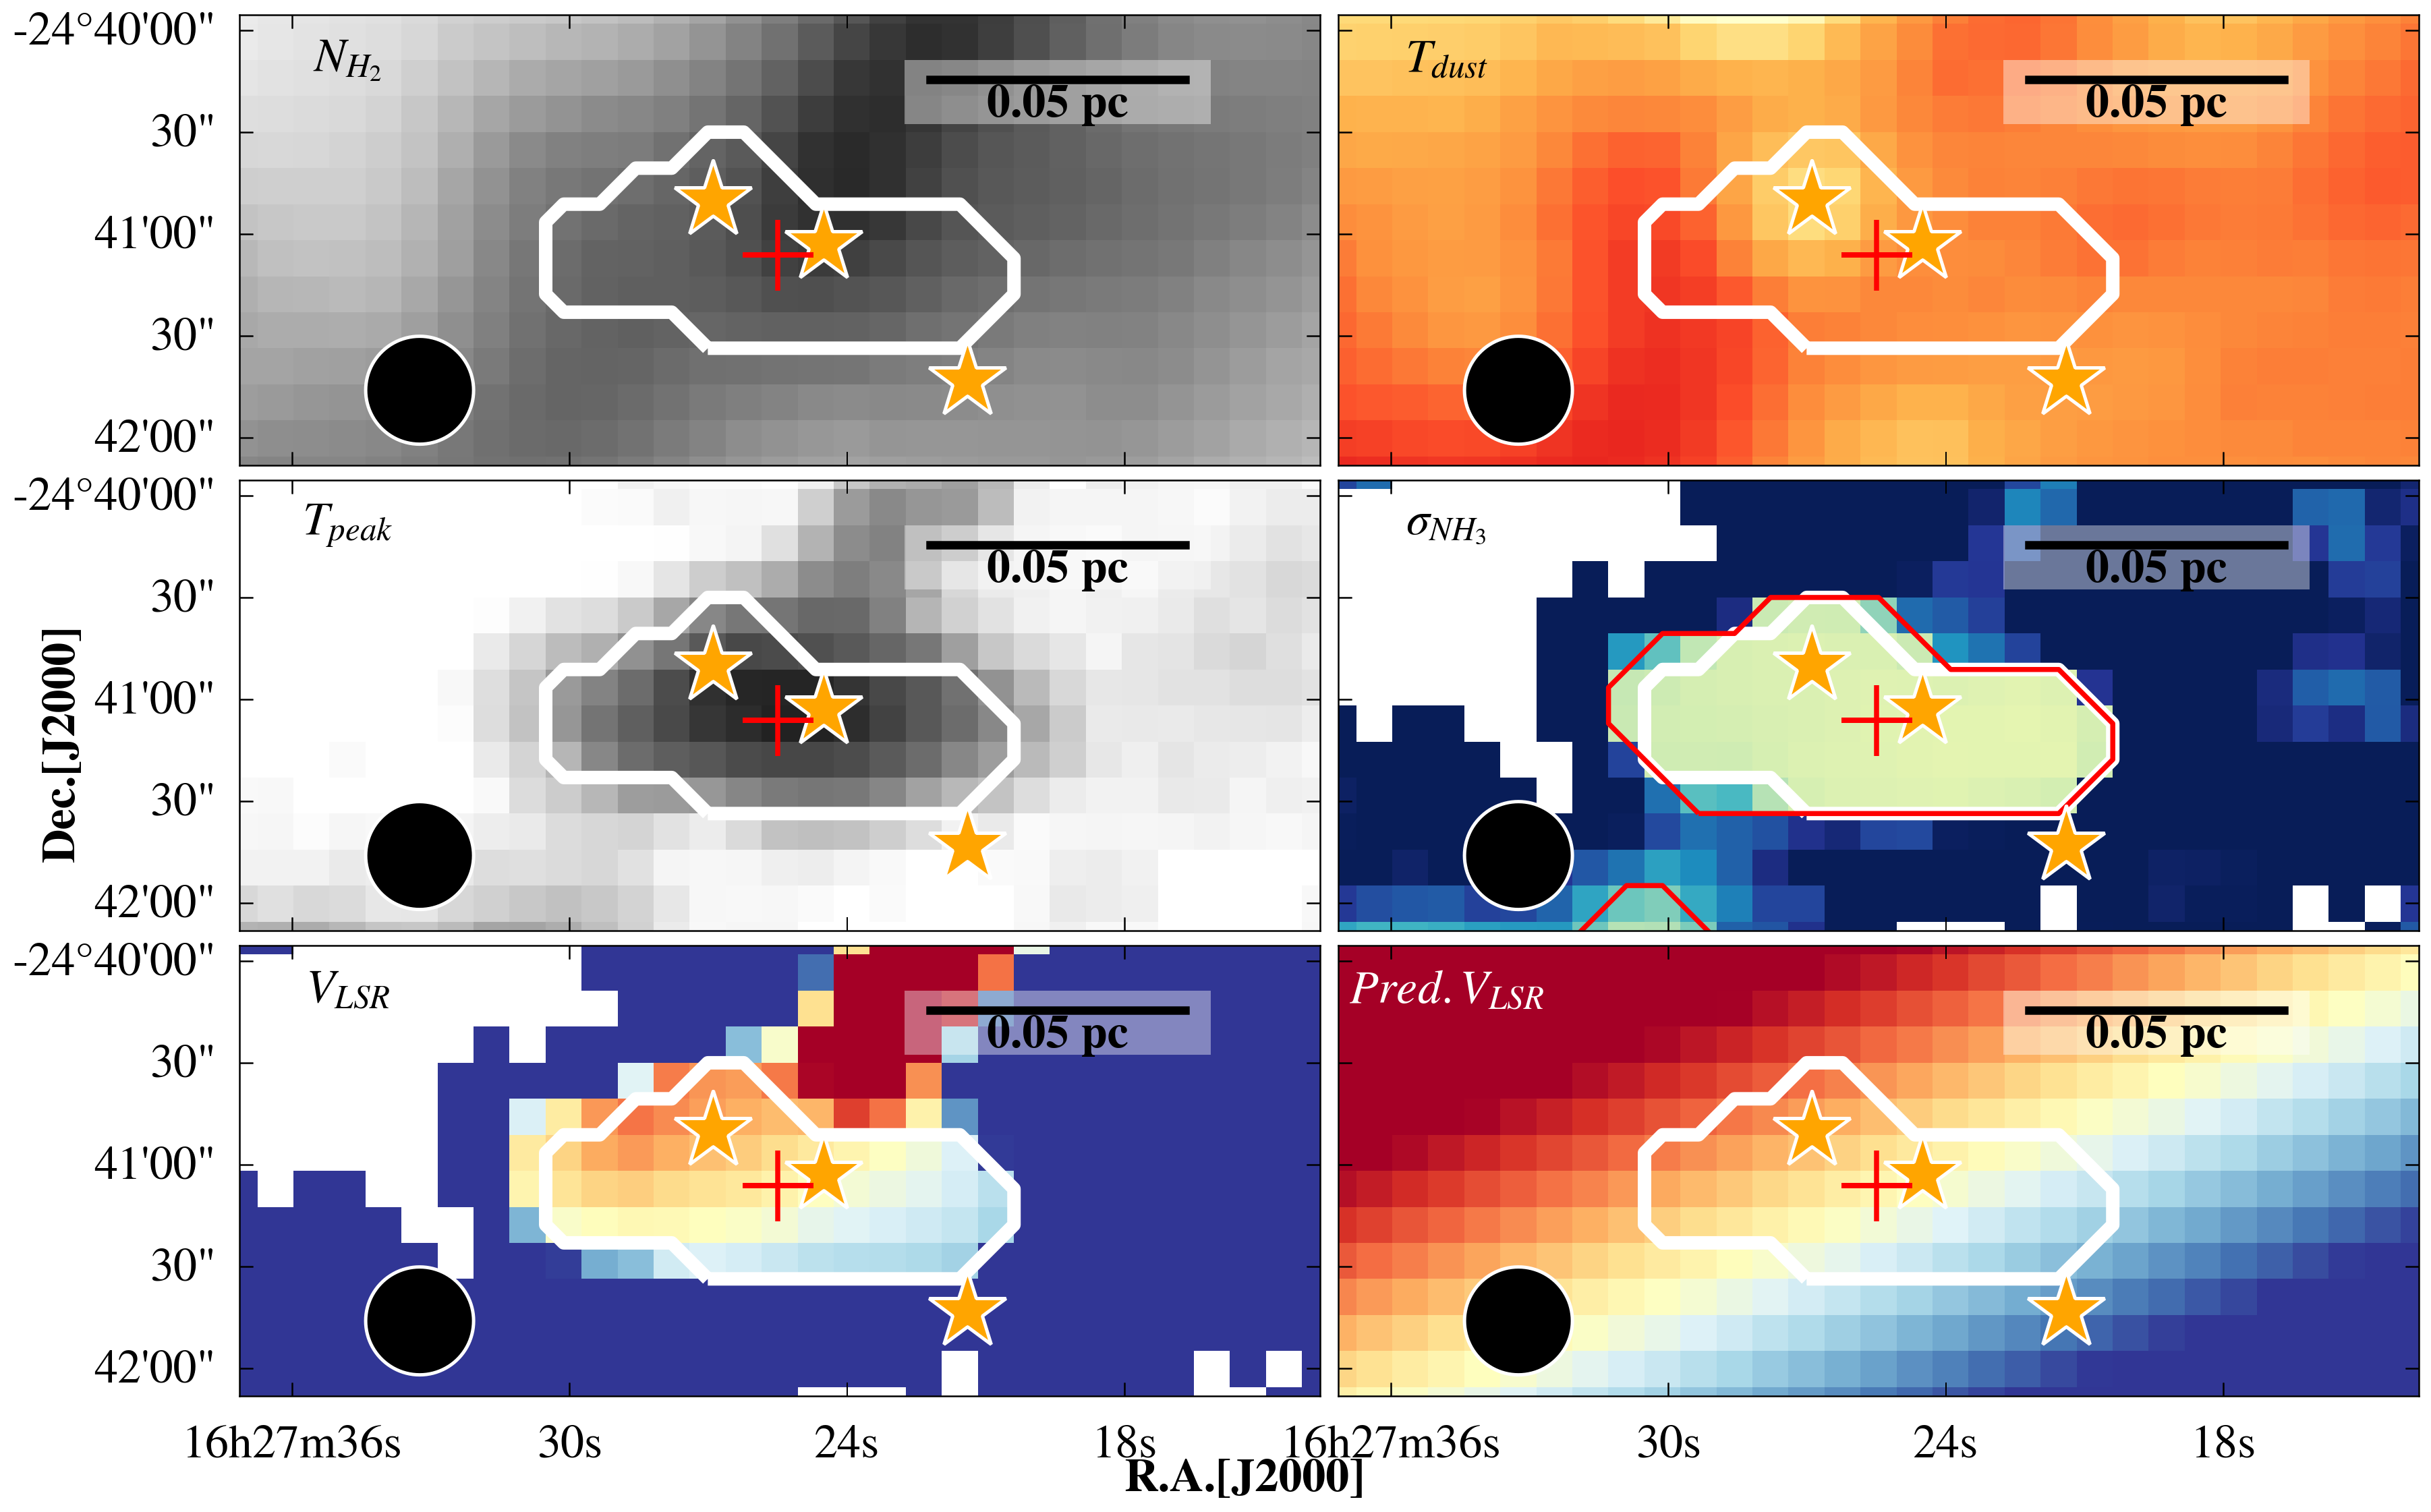

In [9]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotDroplet('L1688', 6, list_dictionaries)  ## <<< Change the code in this line!

In [10]:
!ls /Users/hopechen/Documents/projects/git_projects/Droplets/Droplets/plots/droplets/

B18_1.png       B18_5.png       L1688_11.png    L1688_4.png     L1688_8.png
B18_2.png       B18_6.png       L1688_12.png    L1688_5.png     L1688_9.png
B18_3.png       L1688_1.png     L1688_2.png     L1688_6.png     L1688_extra.png
B18_4.png       L1688_10.png    L1688_3.png     L1688_7.png


[**Figure 2.**](#fig-skymaps)<a id='fig-skymaps'></a> **Maps of the *Herschel* column density ($N_{\text{H}_2}$), the *Herschel* dust temperature ($T_\text{dust}$), the NH$_3$ peak main beam temperature ($T_\text{peak}$), the NH$_3$ kinetic temperature ($T_\text{kin}$), the velocity centroids ($V_\text{LSR}$), and the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), of the entire region.**  The colored contours mark the boundaries of the droplets in the region.  The star symbols denote the positions of Class 0/I and flat spectrum YSOs from the YSO catalogs ([Dunham et al., 2015](https://ui.adsabs.harvard.edu/#abs/2015ApJS..220...11D/abstract); [Rebull et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010ApJS..186..259R/abstract)).  The GBT FWHM beam at 23 GHz is shown on the bottom left of each panel.  *User's choice: A box could be plotted to highlight the region shown in [Figure 1](#fig-droplet).*  [***Change the code to view either L1688 or B18 (the first input of the function "`plotRegion`".  Input a structure number to the variable "`chooseStructure`" to highlight the structure (from 1 to 12 for L1688; from 1 to 6 for B18; L1688 also has an "extra" core that does not satisfy all the criteria, but is include for comparison).  The static version of the plots can be found in the [github `./plots/regionMaps/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/regionMaps).***]

[*The code for plotting this figure is wrapped in the `plotRegion` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

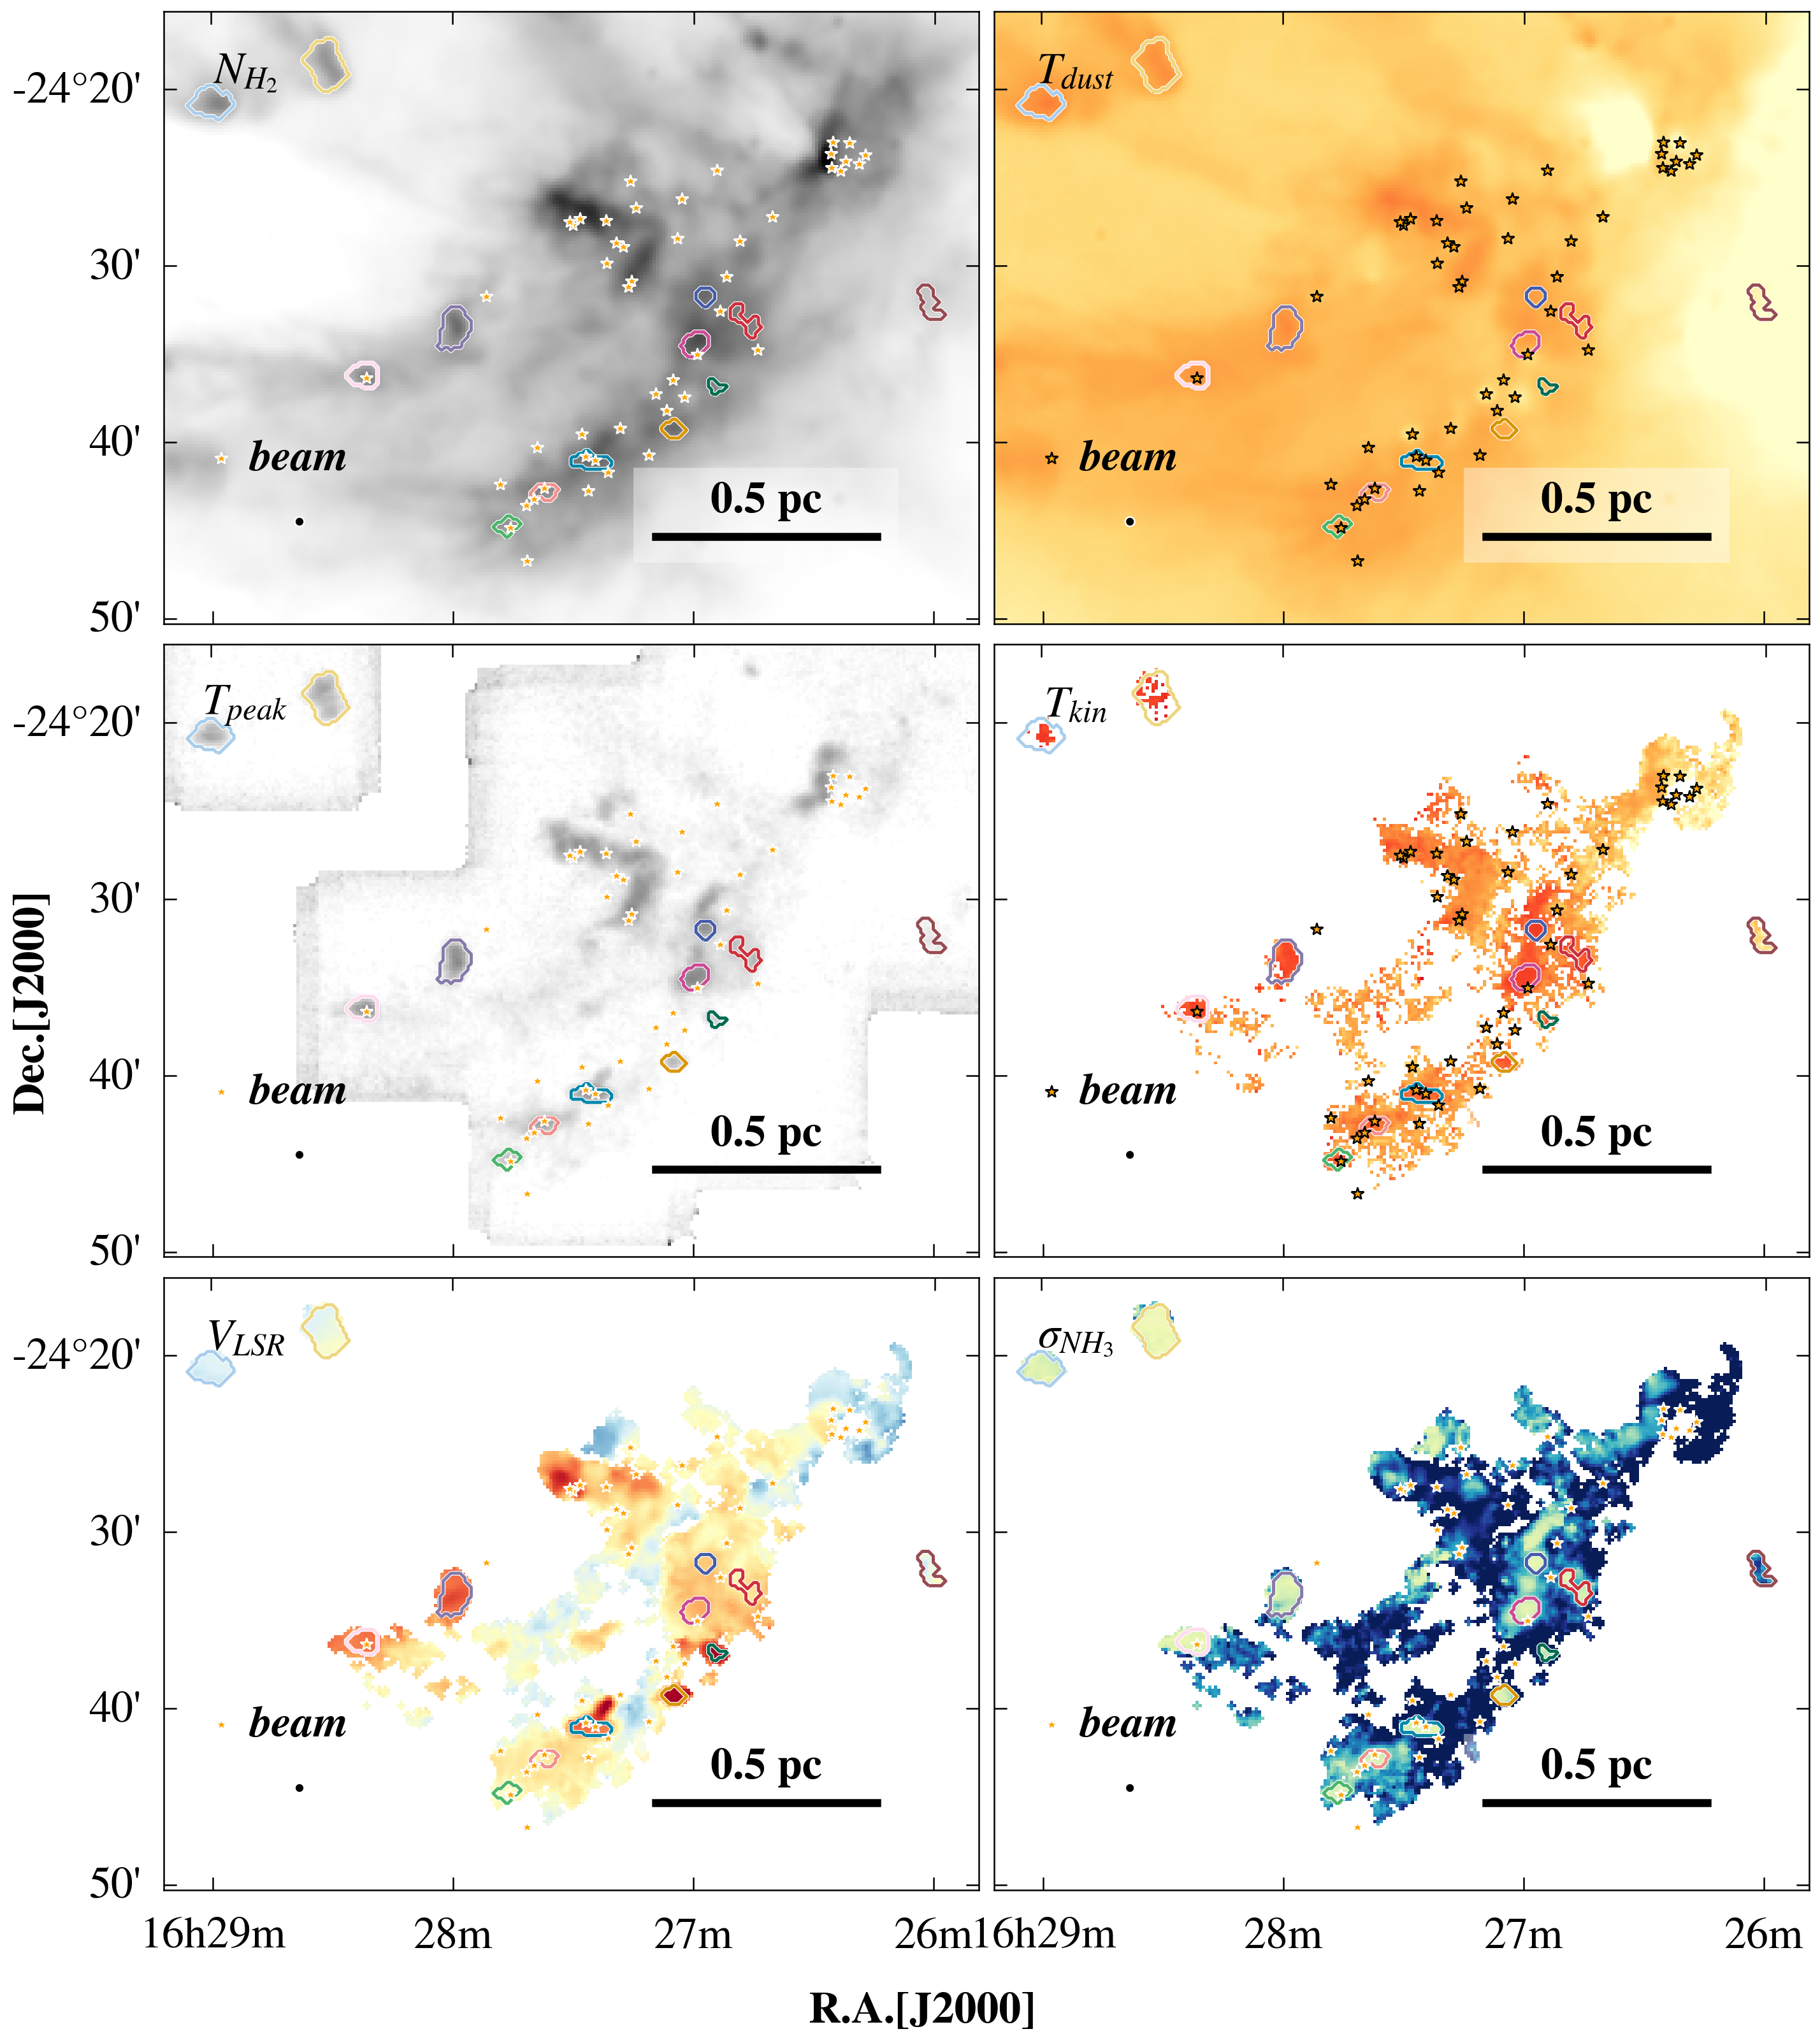

In [11]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotRegion('L1688', list_dictionaries, chooseStructure = 6)  ## <<< Change the code in this line!

<a id='coherence'></a>
### I.1 The *Coherence* of the Structures

Since [Goodman et al. (1998)](https://ui.adsabs.harvard.edu/#abs/1998ApJ...504..223G/abstract), multiple attempts to observe the coherent cores have been made (for example, [Caselli et al., 2002](https://ui.adsabs.harvard.edu/#abs/2002ApJ...572..238C/abstract)).  As described in the previous paragraphs, one key property of such coherent cores is a sharp transition from supersonic velocity dispersion outside the core to subsonic velocity dispersion inside.  In the first direct observations of a coherent core in the B5 region in Perseus, [Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract) shows that the NH$_3$ velocity dispersion decreases with increasing peak antenna temperature around the coherent core ([Figure 4 in Pineda et al., 2010](http://www.astroexplorer.org/details/apjl340752f4)), with the increasing peak temperature serving as a proxy for increasing density.  Here we examine L1688 and B18 in similar plots of the NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, and the peak main beam temperature, $T_\text{peak}$, in [Figure 3](#fig-banana).  We find that a similar trend exists for the L1688 and B18 regions.  We also find that the target structures defined in [Section I](#identification) sits at the low velocity dispersion-high peak main beam temperature end of the trend, similar to the coherent core in B5 ([Pineda et al. (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...712L.116P/abstract)).

[**Figure 3.**](#fig-banana)<a id='fig-banana'></a> **$\sigma_{\text{NH}_3}$ as a function of $T_\text{peak}$, for both L1688 and B18.**  The colored dots are values measured at pixels inside the target structures, color coded correpondingly to the colors of contours in [Figure 2](#fig-skymaps); the gray dots represent the rest of the pixels.  The contours show the cumulative distributions, each of which encircles 25%, 50%, 75%, or 95% of the pixels.  The horizontal lines represent the expected NH$_3$ linewidths ($\sigma_{\text{NH}_3}$) when the non-thermal component ($\sigma_\text{NT}$) is equal to the sonic and half sonic speed ($c_\text{s,ave}$) of average particles, at $T_\text{kin} = 10\ K$. [***Change the `xscale` input to plot $T_\text{peak}$ on the logarithmic or the linear scale (`'log'` or `'linear'`).  The static version of the plots can be found in the [github `./plots/TpeakSigma/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/TpeakSigma).***]

[*The code for plotting this figure is wrapped in the `plotTpeakSigma` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

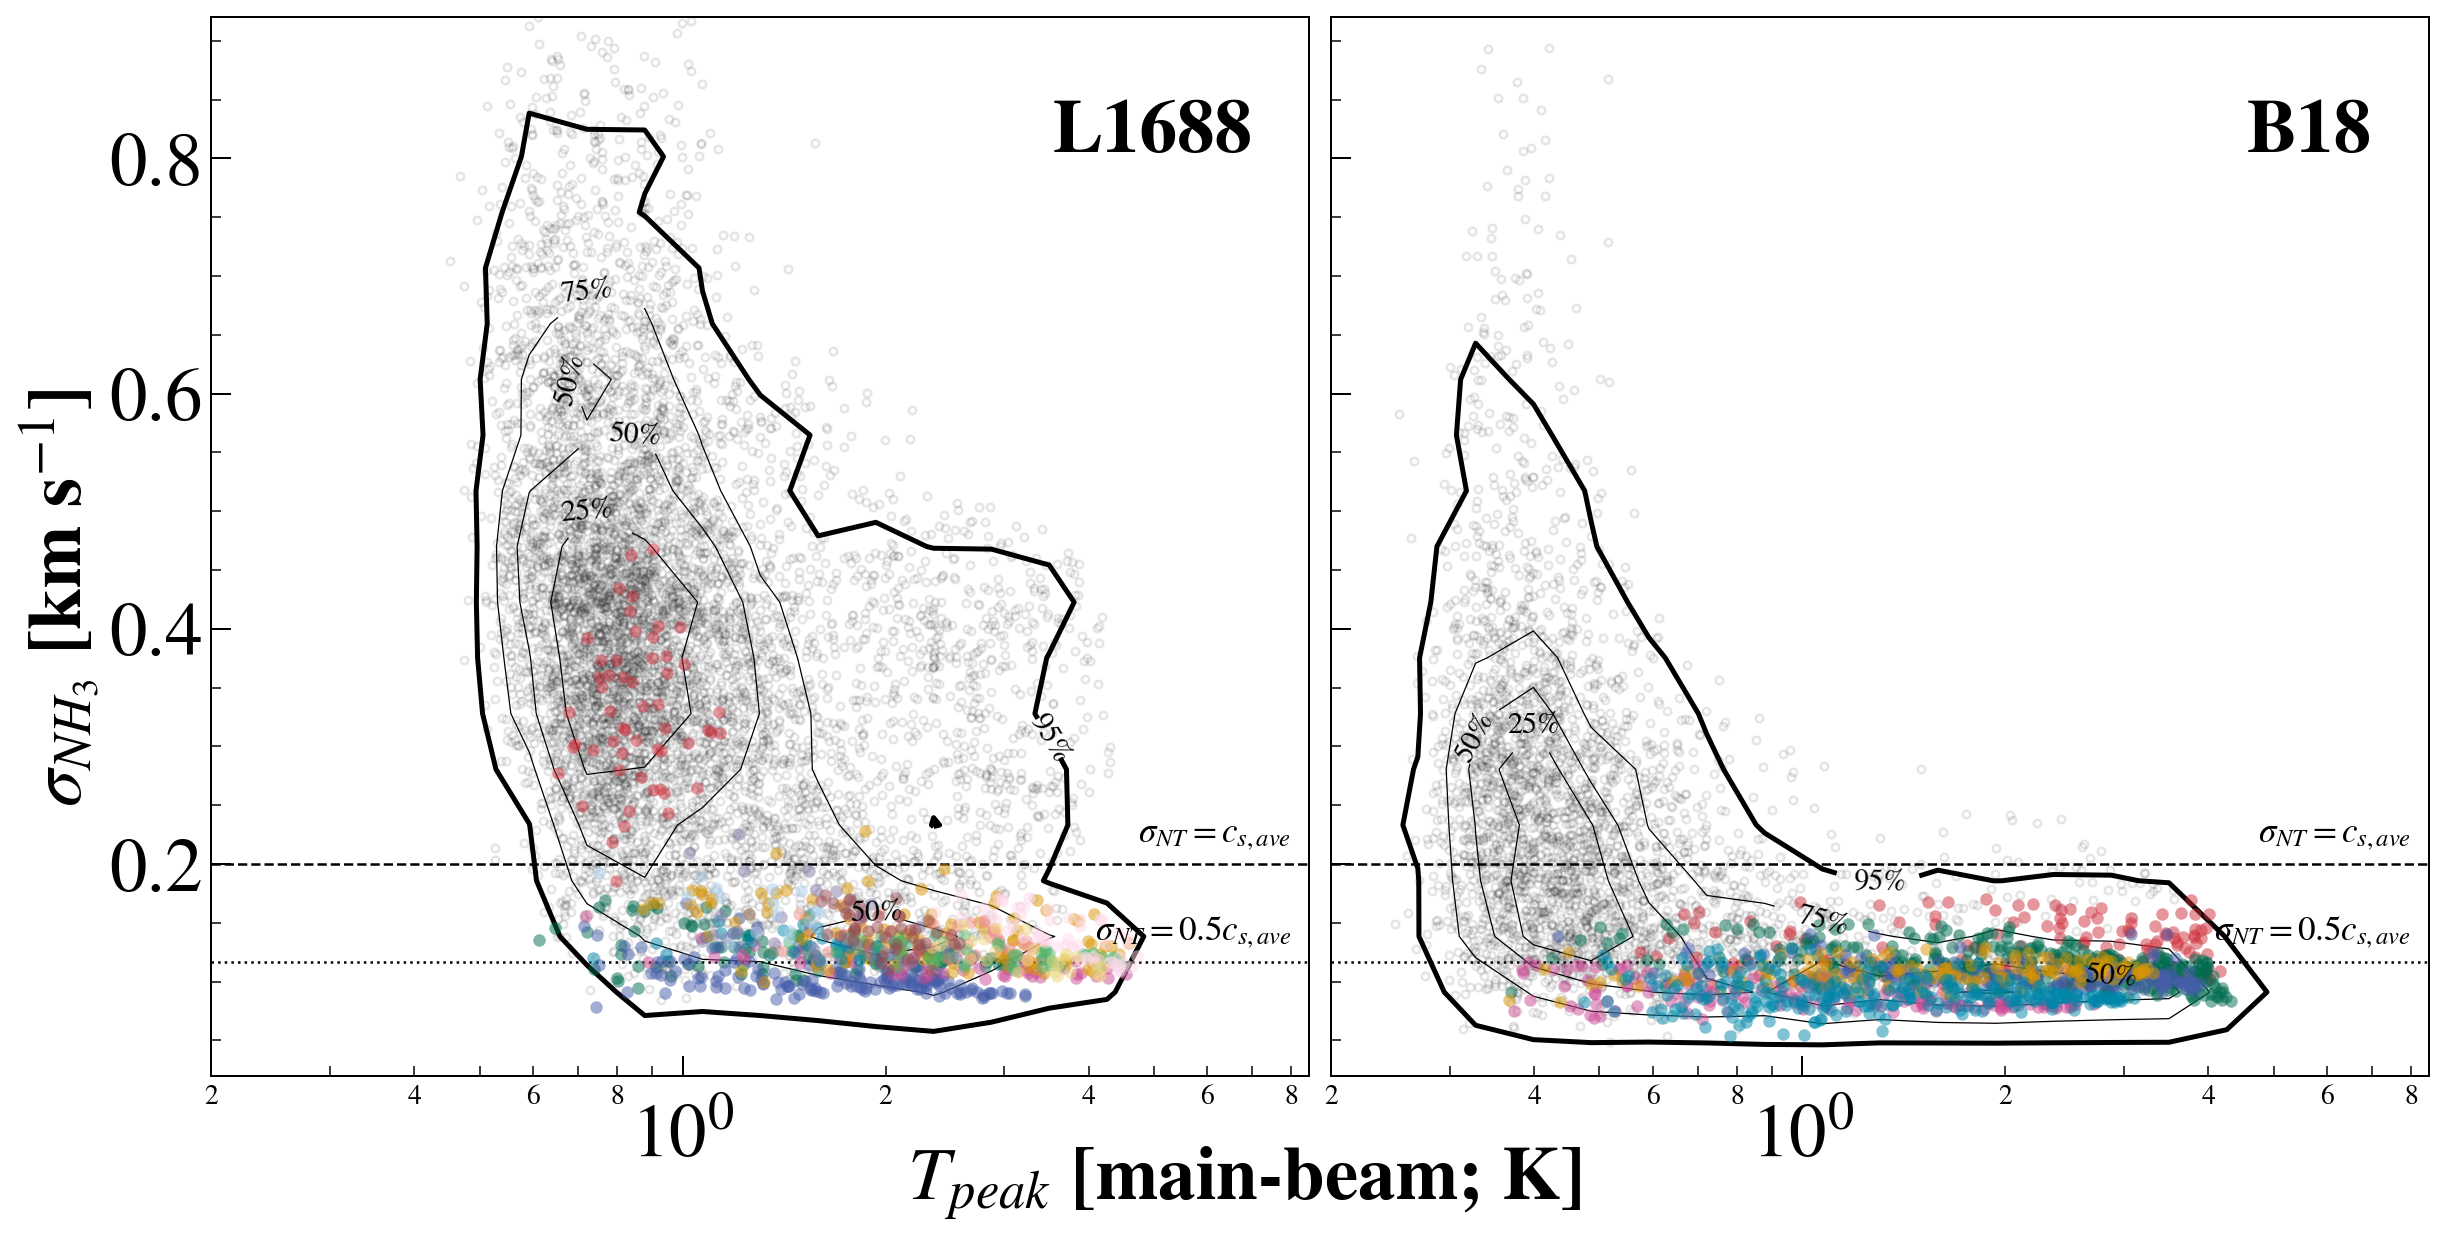

In [12]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotTpeakSigma(list_dictionaries, xscale = 'log')  ## <<< Change the code in this line!

The radial profiles of found structures also demonstrate that these strcutures have subsonic velocity dispersions and show sharp transitions from supersonic to subsonic velocity dispersions at the edge where measurements are available (limited by the detection of NH$_3$ (1, 1) line emission; [Figure 4](#fig-sigmaProfile)).  And generally, the thermal component of the velocity dispersion is larger than the non-thermal component ([Figure 5](#fig-componentsProfile)), again, where the measurements are available.

[Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) used the 3-$\sigma$ S/N level in the NH$_3$ (1, 1) line emission to mask out points with low detection levels/high uncertainties in the fitting of $\sigma_{\text{NH}_3}$, $V_\text{LSR}$, and $T_\text{ex}$; and added the 3-$\sigma$ S/N level in the NH$_3$ (2, 2) emission to mask out points with high uncertainties in the fitting of $T_\text{kin}$ and $N_{\text{NH}_3}$.  Since the calculation of $\sigma_\text{T}$ and $\sigma_\text{NT}$ requires both $\sigma_{\text{NH}_3}$ and $T_\text{kin}$, there are fewer available pixels where we have confident measurements of $\sigma_\text{T}$ and $\sigma_\text{NT}$.  This results in fewer solid dots found inside the effective radius in [Figure 5](#fig-componentsProfile).

[**Figure 4.**](#fig-sigmaProfile)<a id='fig-sigmaProfile'></a> **The radial profile of NH$_3$ velocity dispersion, $\sigma_{\text{NH}_3}$, of each structure.**  The solid green dots represent $\sigma_{\text{NH}_3}$ measured at pixels inside each structure, and the transparent green band shows 1-$\sigma$ distribution of $\sigma_{\text{NH}_3}$ measured at all pixels within each radius bin of a width $\sim0.01$ pc.  The horizontal dashed and dotted lines represent the expected $\sigma_{\text{NH}_3}$ when the nonthermal component equals to the sonic and half sonic speeds of average particles at $T_\text{kin} = 10\ K$, *i.e.* $\sigma_\text{NT}=c_\text{s,ave}$ and $\sigma_\text{NT}=0.5\ c_\text{s,ave}$.  The vertical line shows the effective radius, $R_\text{eff}$, of each structure, and the transparent gray band shows the uncertainty of $R_\text{eff}$.  Similar plots for the thermal and the non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$) are shown in [Figure 5](#fig-componentsProfile).  The structure numbering is shown in the upper right corner.  [***The `plotSigma` input can be changed to plot the thermal and the non-therma components of the velocity dispersion, which is shown in [Figure 5](#fig-componentsProfile).  The static version of the plot can befound at the [github `./plots/Sigmas/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/Sigmas).***]

[*The following code cell could generate a `RuntimeWarning`, because the maps of velocity dispersions include pixels flagged for bad fits and thus having NaN values.  The `RuntimeWarning` occurs when the distance bin contains only pixels with NaN values.  The code for plotting this figure is wrapped in the `plotSigmas` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
//anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


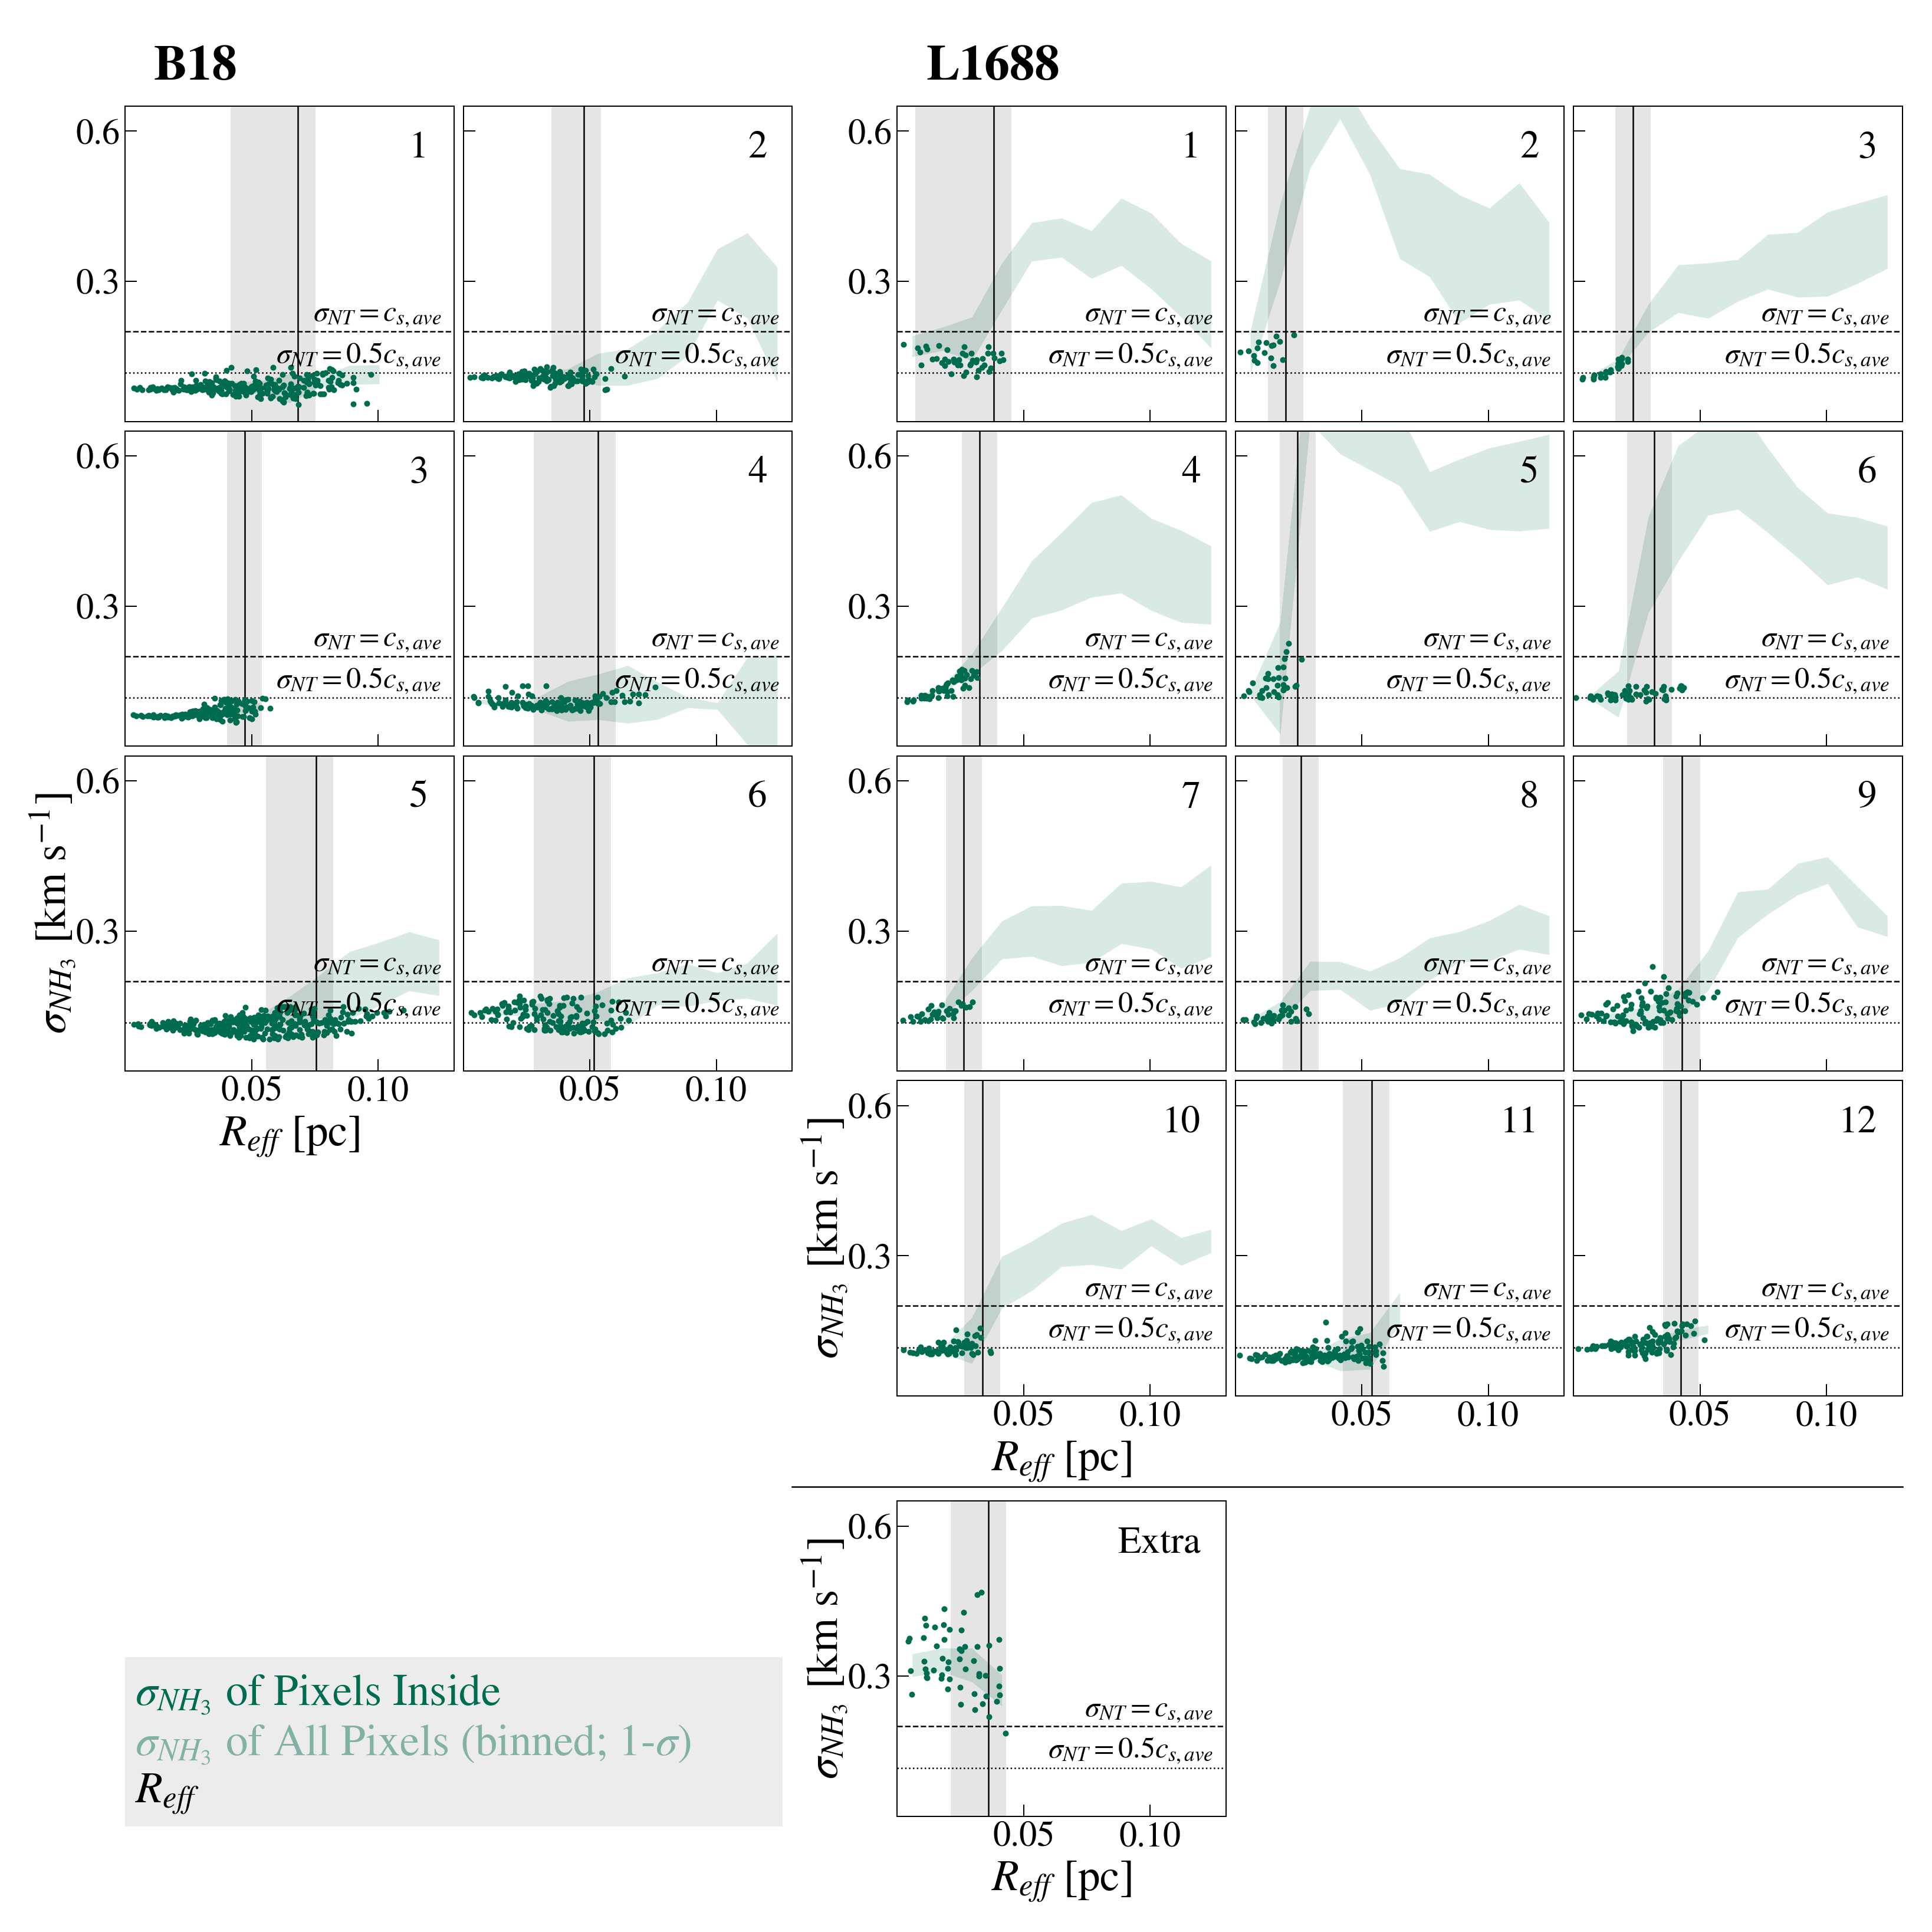

In [32]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotSigmas(list_dictionaries, plotSigma = 'sigma', plotRfromA = False)## <<< See below for plotting components!

[**Figure 5.**](#fig-componentsProfile)<a id='fig-componentsProfile'></a> **Similar to [Figure 4](#fig-sigmaProfile), showing the profiles of the thermal and non-thermal components of velocity dispersion ($\sigma_\text{T}$ and $\sigma_\text{NT}$), of each structure.**  The solid red dots are $\sigma_\text{T}$ measured at pixels inside each structure, and the solid blue dots, $\sigma_\text{NT}$.  The transparent red and blue bands show 1-$\sigma$ distribution of $\sigma_\text{T}$ and $\sigma_\text{NT}$ measured at all pixels within each radius bin of a width $\sim0.01$ pc.  The horizontal dashed and dotted lines show the sonic and half sonic speeds of average particles at $T_\text{kin}=10\ K$.  (The sonic speeds are directly comparable to the thermal velocity dispresion, so they are plotted instead of the expected $\sigma_{\text{NH}_3}$.)  Similar to [Figure 4](#fig-sigmaProfile), the vertical line shows the effective radius of each structure.  The structure numbering is shown in the upper right corner.  [***The `plotSigma` input can be changed to plot the NH$_3$ velocity dispersion, which is shown in [Figure 4](#fig-sigmaProfile).  The static version of the plot can befound at the [github `./plots/Sigmas/` folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/plots/Sigmas).***]

[*The following code cell could generate a `RuntimeWarning`, because the maps of velocity dispersions include pixels flagged for bad fits and thus having NaN values.  The `RuntimeWarning` occurs when the distance bin contains only pixels with NaN values.  The code for plotting this figure is wrapped in the `plotSigmas` function in [`Droplets.py`](https://github.com/hopehhchen/Droplets/blob/master/Droplets/Droplets.py).*]

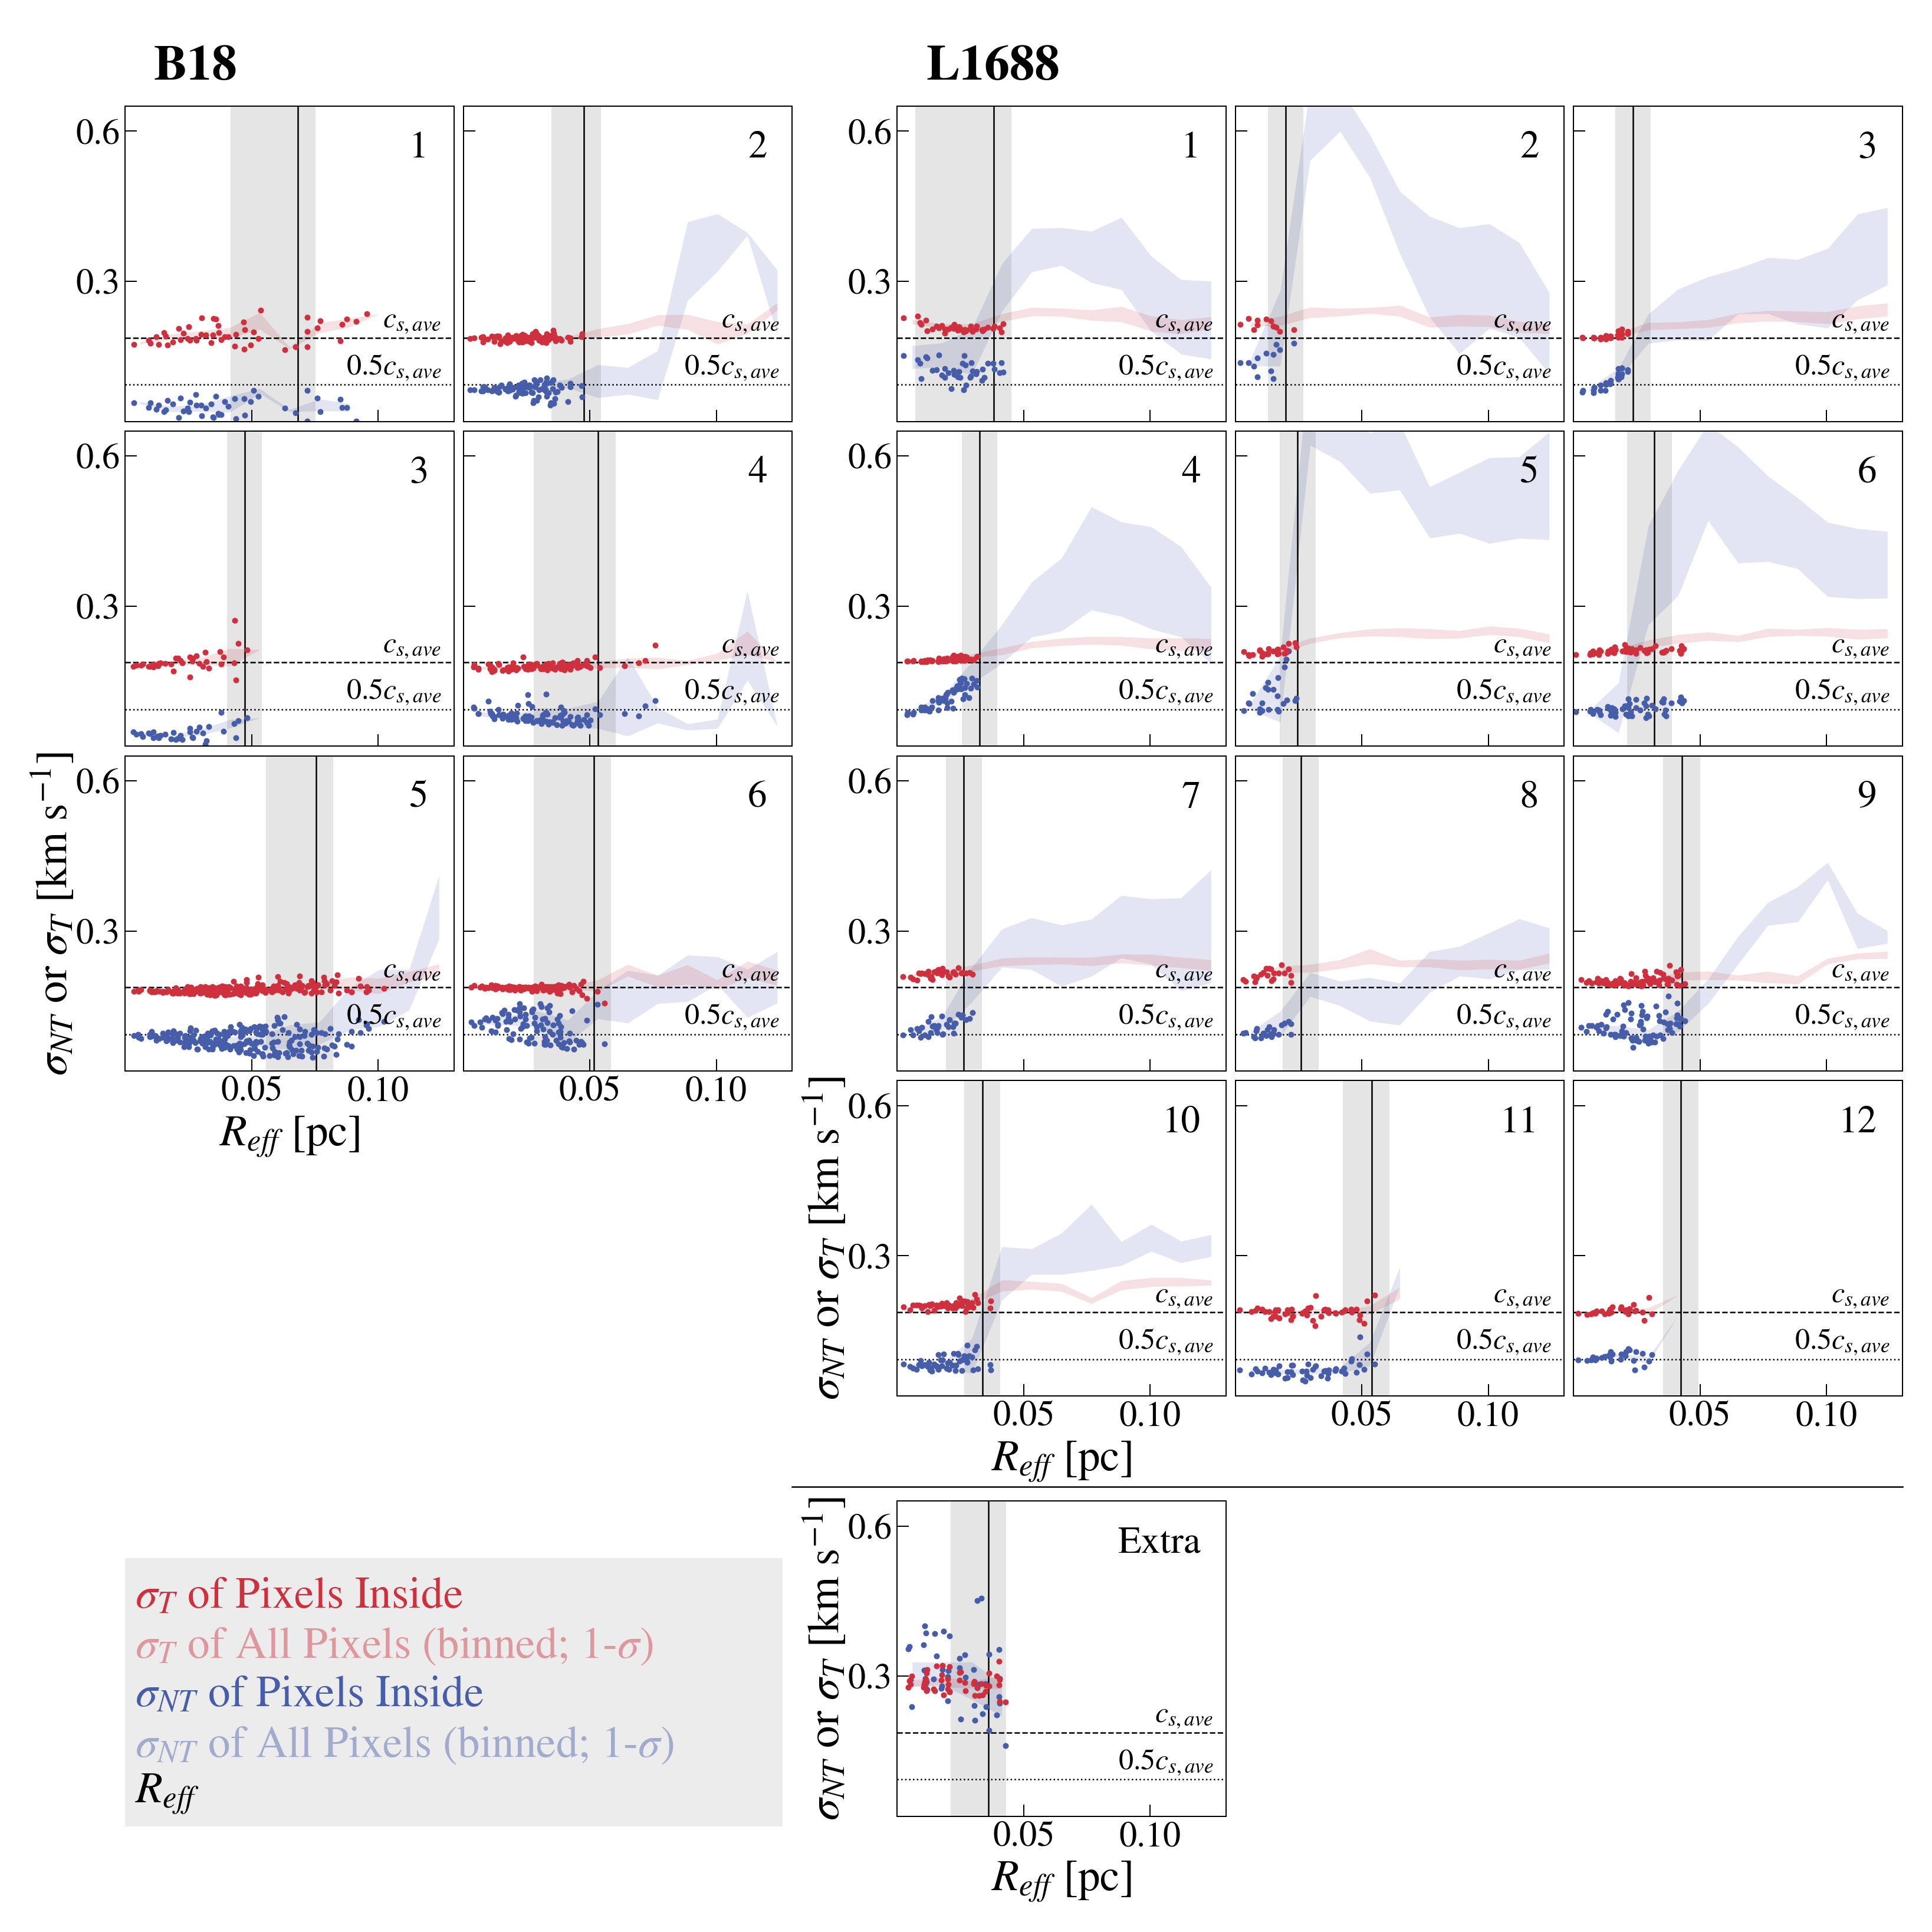

In [33]:
list_dictionaries = [dict_data, dict_masks, dict_YSOs, dict_Vlsr_predicted]
fig = plotSigmas(list_dictionaries, plotSigma = 'components', plotRfromA = False)## <<< See above for plotting sigma!

<a id='properties'></a>
## II. Physical Properties of Droplets

With the property maps from the GAS DR1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract); the original data are in the designated [dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project) and the maps used in analyses below are in the [github ./data/GAS_DR1/ folder](https://github.com/hopehhchen/Droplets/tree/master/Droplets/data/GAS_DR1)), we can derive basic physical properties including the mass, the size, and the velocity dispersion of each structure (for definition of structures, see [Section I](#identification)).  We can then analyze the velocity features, including the gradient and the dispersion, and compare them to that of structures presented by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).

### II.1 Basic Properties (*Mass*, *Size*, and *Velocity Dispersion*)
Before analyzing the velocity features of the structures defined using data from the GAS DR1 [(Friesen and Pineda et al., 2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract), we compare their basic physical properties to that of the structures presented by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), including their mass, size, and velocity dispersion.

The mass ($M$), the size (characterized by $R_\text{eff}$), and the velocity dispersion ($\sigma_\text{tot}$) are often related to each other through the so-called *Larson's Law* [(Larson, 1981)](https://ui.adsabs.harvard.edu/#abs/1981MNRAS.194..809L/abstract).  Even though there are later updates on the relationship between the mass, the size, and the velocity dispersion (**refs xx**), as well as observations that show deviations from the original *laws* (**refs xx**), we use it as as a reference point in our comparison of these physical properties between the structures presented in this work and by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  We do not intend to provide a quantitative update on *Larson's Law*.  The following analyses present characteristic distributions of the *droplets* in the parameter spaces, and through these analyses, we confirm that the *droplets* sit at the lowest end of a continuous relationship between the mass, the size, and the velocity dispersion at larger scales.

Similar to Table 1 in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), we derive a catalog of the target structures in this paper with their basic properties including: the distance ($D$), the celectial coordinates (R.A. and Dec., in the FK5 J2000.0 frame), the velocity centroid in the LSR frame ($V_\text{LSR}$), the kinetic temperature ($T_\text{kin}$), the NH$_3$ velocity dispersion ($\sigma_{\text{NH}_3}$), the total velocity dispersion ($\sigma_\text{tot}$) and its thermal and non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$), the mass ($M$), the FWHMs along the major and minor axes ($r_\text{major}$ and $r_\text{minor}$), the effective radius ($R=\sqrt{r_\text{major}\times r_\text{minor}}$), the shape positional angle ($PA_\text{shape}$), and the axis ratio ($AR$).  We also estimate the uncertainty of each property.  The uncertainties of properties that are derictly derived from the property maps in the GAS DR1 are estimated from the corresponding error maps.  The uncertainties of properties calculated from properties directly derived from the maps are estimated through error propagation, assuming there is no correlation among the properties.

Details of how to derive each property are given below:

1. **Distance ($D$)**: For L1688 in Ophiuchus, we adopt a distance of 137.3±3 pc to the Ophiuchii cluster (conventionally named "$\rho$ Oph"), as measured using parallax of stellar systems with Very Long Baseline Array (VLBA) observations by [Ortiz-León et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract).  For B18 in Taurus, we adopt a distance of 135±20 pc to the molecular cloud in Taurus, as measured using Pan-STARRS1 photometry by [Schlafly et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract).  These are also the distances used by [Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) for the GAS DR1.

2. **Celectial Coordinates (R.A. and Dec.)**: The position of each target structure corresponds to the centroid weighted by the peak NH$_3$ main beam temperature ($T_\text{peak}$).  The coordinates are in the FK5 frame, with the equinox set to J2000.0.  See [Figure 1](#fig-droplet) for where the centroid sits with respect to the boundary.

3. **LSR Velocity ($V_\text{LSR}$)**: The LSR velocity of each structure is estimated by calculating the median of the velocity centroids at pixels within the boundary.

4. **Kinetic Temperature ($T_\text{kin}$)**: The kinetic temperature is the median of $T_\text{kin}$ at pixels within the boudnary.  Notice that to be able to fit for $T_\text{kin}$, there has to be substantial detection of both NH$_3$ (1, 1) and (2, 2) line emission.  In the GAS DR1, both (1, 1) and (2, 2) lines have to have signal-to-noise ratios of ≥3 to be included in the resulting property map of kinetic temperature.

5. **NH$_3$ Velocity Dispersion ($\sigma_{\text{NH}_3}$)**: The NH$_3$ velocity dispersion is the median of $\sigma$ in the fitted Gaussian profiles for pixels within the boundary.

6. **Total Velocity Dispersion ($\sigma_\text{tot}$)**: With the kinetic temperature and the NH$_3$ velocity dispersion, we can derive the total velocity dispersion ([Eq. 1](#eq-Sigma)).  Here we calculate $\sigma_\text{tot}$ from the measured (median) $T_\text{kin}$ and $\sigma_{\text{NH}_3}$, instead of taking the median value on the map of total velocity dispersion derived in [Section 0.1](#data).

7. **Thermal Component of Velocity Dispersion ($\sigma_\text{T}$)**: We can also calcualte the thermal component of the velocity dispersion from $T_\text{kin}$ ([Eq. 2](#eq-SigmaT)).  We calculate $\sigma_\text{T}$ from the measured $T_\text{kin}$, instead of taking the median value on the map of the velocity dispersion thermal component derived in [Section 0.1](#data).  This guarantees that the squared sum of the thermal and non-thermal velocity dispersion components is equal to the total velocity dispersion fro each target structure (see [Eq. 4](#eq-SigmaSum)).

8. **Non-thermal Component of Velocity Dispersion ($\sigma_\text{NT}$)**: Similarly, we can calculate the non-thermal component of the velocity dispersion from the kinetic temperature and the NH$_3$ velocity dispersion ([Eq. 3](#eq-SigmaNT)).  Here we calculate $\sigma_\text{tot}$ from the measured (median) $T_\text{kin}$ and $\sigma_{\text{NH}_3}$, instead of taking the median value on the map of total velocity dispersion derived in [Section 0.1](#data).  This guarantees that the squared sum of the thermal and non-thermal velocity dispersion components is equal to the total velocity dispersion fro each target structure (see [Eq. 4](#eq-SigmaSum)).

9. **Mass ($M$)**: The mass of each target structure is derived from the Herschel column density map (see [Section 0.I](#data)).

10. **FWHMs along the major and the minor axes ($r_\text{major}$ and $r_\text{minor}$)**: We first determine the major axis by finding the spatial direction that explains most of the spatial distribution of each target structure.  The calculation is weighted by the peak NH$_3$ temperature in the main-beam unit, which is characteristic of the internal gas density structure.  The minor axis is then the spatial direction that is perpendicular to the major axis.  We then calculate the 2nd moments of spatial distribution projected onto the major and the minor axes.  The FWHMs are then estimated through the conversion with a constant factor, $\text{FWHM} = 2\sqrt{2 \ln{2}} \times \sigma$, where $\sigma$ is the 2nd moment along the major or the minor axis.

11. **Effective Radius ($R_\text{eff}$)**: The effective radius is the geometric mean of the FWHMs along the major and the minor axes.  See [Eq. 5](#eq-Reff).

12. **Shape Positional Angle ($\text{PA}_\text{shape}$)**: The shape positional angle is simply the position angle of the major axis derived above.

13. **Aspect Ratio ($\text{AR}$)**: The aspect ratio is the ratio between the FWHMs along the major and the minor axes.  That is, $\text{AR}=r_\text{major}/r_\text{minor}$.

In [22]:
dict_table1 = defaultdict(list)
list_columns = ['ID', 'D', 'eD', 'RA', 'Dec',
                'Vlsr', 'eVlsr', 'Tkin', 'eTkin', 'Sigma', 'eSigma',
                'SigmaTot', 'eSigmaTot', 'SigmaT', 'eSigmaT', 'SigmaNT', 'eSigmaNT',
                'M', 'eM', 'major', 'emajor', 'minor', 'eminor', 'Reff', 'eReff',
                'PA', 'AR', 'eAR']

for reg in ['L1688', 'B18']:
    
    if reg == 'L1688':
        listStructures = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listStructures = range(1, 7)
    
    
    # header
    header = dict_data[reg]['header_GAS']
    ## scales with astropy units
    distance = distances[reg]
    edistance = distances[reg+'_e']
    pixscale = np.radians(abs(header['CDELT1']))*distance
    epixscale = np.radians(abs(header['CDELT1']))*edistance
    # property maps
    ## Tpeak and statistics
    mapTpeak = dict_data[reg]['Tpeak']
    ## Vlsr
    mapVlsr = dict_data[reg]['Vlsr']
    mapVlsr_e = dict_data[reg]['eVlsr']
    ## Tkin
    mapTkin = dict_data[reg]['Tkin']
    mapTkin_e = dict_data[reg]['eTkin']
    ## SigmaNH3
    mapSigma = dict_data[reg]['Sigma']
    mapSigma_e = dict_data[reg]['eSigma']
    ## column density
    mapColden = dict_data[reg]['colden']
    mapColden_e = dict_data[reg]['ecolden']
    
        
    for structure in listStructures:
        
        # Prepare the property maps
        ## mask
        mask = dict_masks[reg][structure]
        ## statistics
        meshx, meshy = np.meshgrid(range(mapTpeak.shape[1]), range(mapTpeak.shape[0]))
        stat = statBasic2D(mapTpeak[mask], (meshy[mask], meshx[mask]))
        stat.calculate()
        
        # structure ID
        ID = reg+'_'+str(structure)
        dict_table1['ID'].append(ID)
        
        # distance (D) in pc
        D = distance.to(u.pc).value
        eD = edistance.to(u.pc).value
        dict_table1['D'].append(D)
        dict_table1['eD'].append(eD)
        
        # RA & Dec
        ceny, cenx = stat.mom1
        RA, Dec = wcs.WCS(header).wcs_pix2world([[cenx, ceny]], 0)[0]
        dict_table1['RA'].append(RA)
        dict_table1['Dec'].append(Dec)
        
        # Vlsr in km/s
        Vlsr = np.nanmedian(mapVlsr[mask])
        eVlsr = np.nanmedian(mapVlsr_e[mask])
        dict_table1['Vlsr'].append(Vlsr)
        dict_table1['eVlsr'].append(eVlsr)
        
        # Tkin in K
        Tkin = np.nanmedian(mapTkin[mask])
        eTkin = np.nanmedian(mapTkin_e[mask])
        dict_table1['Tkin'].append(Tkin)
        dict_table1['eTkin'].append(eTkin)
        
        # SigmaNH3 in km/s
        Sigma = np.nanmedian(mapSigma[mask])
        eSigma = np.nanmedian(mapSigma_e[mask])
        dict_table1['Sigma'].append(Sigma)
        dict_table1['eSigma'].append(eSigma)
        
        # Sigmas
        ## SigmaT in km/s
        SigmaT = np.sqrt(c.k_B*Tkin*u.K/mass['average'])
        eSigmaT = .5*np.sqrt(2.37*u.u/(c.k_B*Tkin*u.K))*(c.k_B/mass['average'])*eTkin*u.K
        dict_table1['SigmaT'].append(SigmaT.to(u.km/u.s).value)
        dict_table1['eSigmaT'].append(eSigmaT.to(u.km/u.s).value)
        ## SigmaNT in km/s
        SigmaNT = np.sqrt((Sigma*u.km/u.s)**2.-c.k_B*Tkin*u.K/mass['NH3'])
        eSigmaNT = (.5*1./np.sqrt((Sigma*u.km/u.s)**2.-c.k_B*Tkin*u.K/mass['NH3']))**2.\
                   *((2.*Sigma*u.km/u.s*eSigma*u.km/u.s)**2.+(-c.k_B/mass['NH3']*eTkin*u.K)**2.)
        eSigmaNT = np.sqrt(eSigmaNT)
        dict_table1['SigmaNT'].append(SigmaNT.to(u.km/u.s).value)
        dict_table1['eSigmaNT'].append(eSigmaNT.to(u.km/u.s).value)
        ## SigmaTot in km/s
        SigmaTot = np.sqrt(SigmaT**2.+SigmaNT**2.)
        eSigmaTot = (.5*1./np.sqrt(SigmaT**2.+SigmaNT**2.))**2.\
                    *((2.*SigmaT*eSigmaT)**2.+(2.*SigmaNT*eSigmaNT)**2.)
        eSigmaTot = np.sqrt(eSigmaTot)
        dict_table1['SigmaTot'].append(SigmaTot.to(u.km/u.s).value)
        dict_table1['eSigmaTot'].append(eSigmaTot.to(u.km/u.s).value)
        
        # mass in Msun
        M = np.nansum((mapColden[mask]-np.nanmin(mapColden[mask]))*u.cm**-2.*mass['average']*pixscale**2.)
        eM = np.nansum((pixscale**2.*mapColden_e[mask]*u.cm**-2.*mass['average'])**2.
                       +((mapColden[mask]-np.nanmin(mapColden[mask]))*u.cm**-2.*mass['average']
                         *(2.*pixscale*epixscale))**2.
                       +(pixscale**2.
                         *mapColden_e[mask][np.nanargmin(mapColden[mask])]*u.cm**-2.*mass['average'])**2.)
        eM = np.sqrt(eM)
        dict_table1['M'].append(M.to(u.Msun).value)
        dict_table1['eM'].append(eM.to(u.Msun).value)
        
        # FWHMs
        ## major axis in pc
        major = pixscale*stat.major_sigma.value*(2.*np.sqrt(2.*np.log(2.)))
        emajor = epixscale*stat.major_sigma.value*(2.*np.sqrt(2.*np.log(2.)))
        dict_table1['major'].append(major.to(u.pc).value)
        dict_table1['emajor'].append(emajor.to(u.pc).value)
        ## minor axis in pc
        minor = pixscale*stat.minor_sigma.value*(2.*np.sqrt(2.*np.log(2.)))
        eminor = epixscale*stat.minor_sigma.value*(2.*np.sqrt(2.*np.log(2.)))
        dict_table1['minor'].append(minor.to(u.pc).value)
        dict_table1['eminor'].append(eminor.to(u.pc).value)
        
        # Reff in pc
        Reff = np.sqrt(major*minor)
        eReff = np.sqrt((.5*(1./np.sqrt(major*minor))*major*eminor)**2.
                        +(.5*(1./np.sqrt(major*minor))*minor*emajor)**2.)
        dict_table1['Reff'].append(Reff.to(u.pc).value)
        dict_table1['eReff'].append(eReff.to(u.pc).value)
        
        # PA shape in degrees, E of N; -90 to 90
        PA = stat.position_angle.value
        if (PA >= 0.) and (PA <= 180.):
            PA = PA - 90.
        elif (PA >= -180.) and (PA < 0.):
            PA = PA + 90.
        dict_table1['PA'].append(PA)
            
        # AR (aspect ratio), dimensionless
        AR = (major/minor).decompose().value
        eAR = np.sqrt((emajor/minor)**2. + (major*eminor/minor**2.)**2.)
        eAR = eAR.decompose().value
        dict_table1['AR'].append(AR)
        dict_table1['eAR'].append(eAR)
        
dict_tables['table1'] = pd.DataFrame(dict_table1,
                                     columns = list_columns)

### II.2 Velocity Gradient and the Related Properties (Velocity Gradient, Rotational Energy Ratio, Specific Angular Momentum)

We then fit the velocity distribution within the boundary of each structure to a 2D 1st-order polynomial (a plane function).  This is the same function [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) fit to.  That is, <a id='eq-gradient'></a>$$V_\text{LSR,fit}=c_xx+c_yy+c_0\ \text{,}\ \ \ \ \ \text{[6]}$$ where $x$ and $y$ are two perpendicular axes on the plane of the sky.  The velocity gradient vector is then a 2D vector constituted of the two 1st-order coefficient, $(c_x, c_y)$, pointing from low to high values of $V_\text{LSR}$ (*i.e.*, from the more blue-shifted end to the more red-shifted end). Here we use R.A. and Dec. as the two axes, but the magnitude of the fitted gradient should be invariant with respect to rotation.

From the velocity gradient ($\mathcal{G}$ as the magnitude and $\text{PA}_\mathcal{G}$ as the direction on the plane of the sky), we derive related properties included in Table 2 in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  These include the total difference in velocity ($\mathcal{G}\times R$), the ratio between the rotational and the gravitational energies ($\beta$), and the specific angular momentum ($J/M$).  The details of how each property is calculated are given below:

1. **Velocity Gradient ($\mathcal{G}$ as the magnitude and $\text{PA}_\mathcal{G}$ as the position angle indicating the direction)**: We fit $V_\text{LSR}$ within the boundary of each structure to a 2D 1st-order polynomial ([Eq. 6](#eq-gradient)).  We then calculate the magnitude and the direction of the resulting velocity gradient vector, $(c_x, c_y)$.  The magnitude is in units of km s$^{-1}$, and the direction is presented as a positional angle in degrees, increasing from zero eastward of North.

2. **Total Difference in Velocity ($\mathcal{G}\times R$)**: Notice that this is simply calculated by multiplying the velocity gradient magnitude by the effective radius.  This would be the exact total difference in velocity in an ideal case where the velocity field *is* a single linear gradient and the core is spherical.

3. **The Ratio between the Rotational and the Gravitational Energy ($\beta$)**: Following Eq. 5 in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), $$\beta = \frac{1}{2}\frac{p}{q}\frac{\omega^2R^3}{GM}\ \text{,}$$ where $p$ and $q$ are the shape parameters that correlate the internal rotational and density structures with the bulk properties.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) defined $p$ and $q$ by $I = pMR^2$ and $\left|E_\text{grav}\right| = qGM^2/R$.  The angular velocity, $\omega$, is assumed to relate to the observed velocity gradient by an inclination angle, $i$, by $\omega=\mathcal{G}/\sin{i}$, assuming that the observed velocity gradient can be fully attributed to the rotation.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) assumed a constant density and a solid-body rotation, corresponding to $p = 2/5$ and $q = 3/5$.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) also assumed that $\sin{i} = 1$.  Note that the assumption relating the observed velocity gradient and the rotational motion is a strong one, and can introduce biases wherever there is core-scale turbulence or internal motion like outflows.

    Even though $\beta$ calculated in this work is directly compared to values presented by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract), the way mass is estimated in this work is critically different from how it was estimated in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  The mass in [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) was taken from [Benson & Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract), which was calculated based on NH$_3$ line fitting.  The model used by [Benson & Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) in the line fitting gives an estimate of total number density, and from the total number density and the effective radius, [Benson & Myers (1989)](https://ui.adsabs.harvard.edu/#abs/1989ApJS...71...89B/abstract) calculated the mass.  In the GAS DR1, however, the model used in NH$_3$ line fitting gives the ammonia column density instead.  Without risking introducing more biases by assuming an abundance, we calculate the mass from the Herschel map, essentially following the "clipping" scheme in [Rosolowsky et al. (2008)](https://ui.adsabs.harvard.edu/#abs/2008ApJ...679.1338R/abstract) and independent from NH$_3$ observations and fitting.

4. **Specific Angular Momentum ($J/M$)**: We can also calculate the specific angular momentum, $J/M = pR^2\omega$, where $p$ is again the coefficient that correlates the moment of intertia, which is dependent on the internal rotational profile, with the bulk measurements of mass and radius, $I = pMR^2$.  Again, the angular velocity, $\omega$, is assumed to relate to the velocity gradient, $\omega = \mathcal{G}/\sin{i}$.  And again, correlating the observed velocity gradient to the intrinsic angular velocity is a strong assumption.

In [ ]:
dict_table1 = defaultdict(list)
list_columns = ['Grad', 'eGrad', 'PAGrad', 'ePAGrad',
                'GxR', 'eGxR', 'beta', 'ebeta', 'JoverM', 'eJoverM']

for reg in ['L1688', 'B18']:
    
    if reg == 'L1688':
        listStructures = list(range(1, 13))+['extra']
    elif reg == 'B18':
        listStructures = range(1, 7)
        
    # header
    header = dict_data[reg]['header_GAS']
    ## scales with astropy units
    distance = distances[reg]
    edistance = distances[reg+'_e']
    pixscale = np.radians(abs(header['CDELT1']))*distance
    epixscale = np.radians(abs(header['CDELT1']))*edistance
    # property maps
    ## Tpeak and statistics
    mapTpeak = dict_data[reg]['Tpeak']
    ## Vlsr
    mapVlsr = dict_data[reg]['Vlsr']
    mapVlsr_e = dict_data[reg]['eVlsr']
    ## Tkin
    mapTkin = dict_data[reg]['Tkin']
    mapTkin_e = dict_data[reg]['eTkin']
    ## SigmaNH3
    mapSigma = dict_data[reg]['Sigma']
    mapSigma_e = dict_data[reg]['eSigma']
    ## column density
    mapColden = dict_data[reg]['colden']
    mapColden_e = dict_data[reg]['ecolden']

### II.3 Full Virial Analysis

### Appendix. Comparison to other works

In [173]:
from astropy.coordinates import SkyCoord
from matplotlib import patches

direcTable = '/Users/hopechen/Documents/projects/git_projects/data/Kirk_Oph/'
testTable = pd.read_csv(direcTable+'L1688-MasterCoreCat-gs.txt',
                        delim_whitespace = True)

In [110]:
testDerived = {'Reff': testTable['EFFRADIUS(pc)'].values,
               'Sigma': testTable['LINEWIDTH(cm/s)'].values/1e5,
               'Tkin': testTable['TKIN(K)'].values}
testDerived['SigmaT'] = np.sqrt(c.k_B*testDerived['Tkin']*u.K/mass['average']).to(u.km/u.s).value
testDerived['SigmaNT'] = np.sqrt((testDerived['Sigma']*u.km/u.s)**2.
                                 -c.k_B*testDerived['Tkin']*u.K/mass['NH3']).to(u.km/u.s).value
testDerived['SigmaTot'] = np.sqrt(testDerived['SigmaT']**2. + testDerived['SigmaNT']**2.)

testDerived = pd.DataFrame(testDerived)

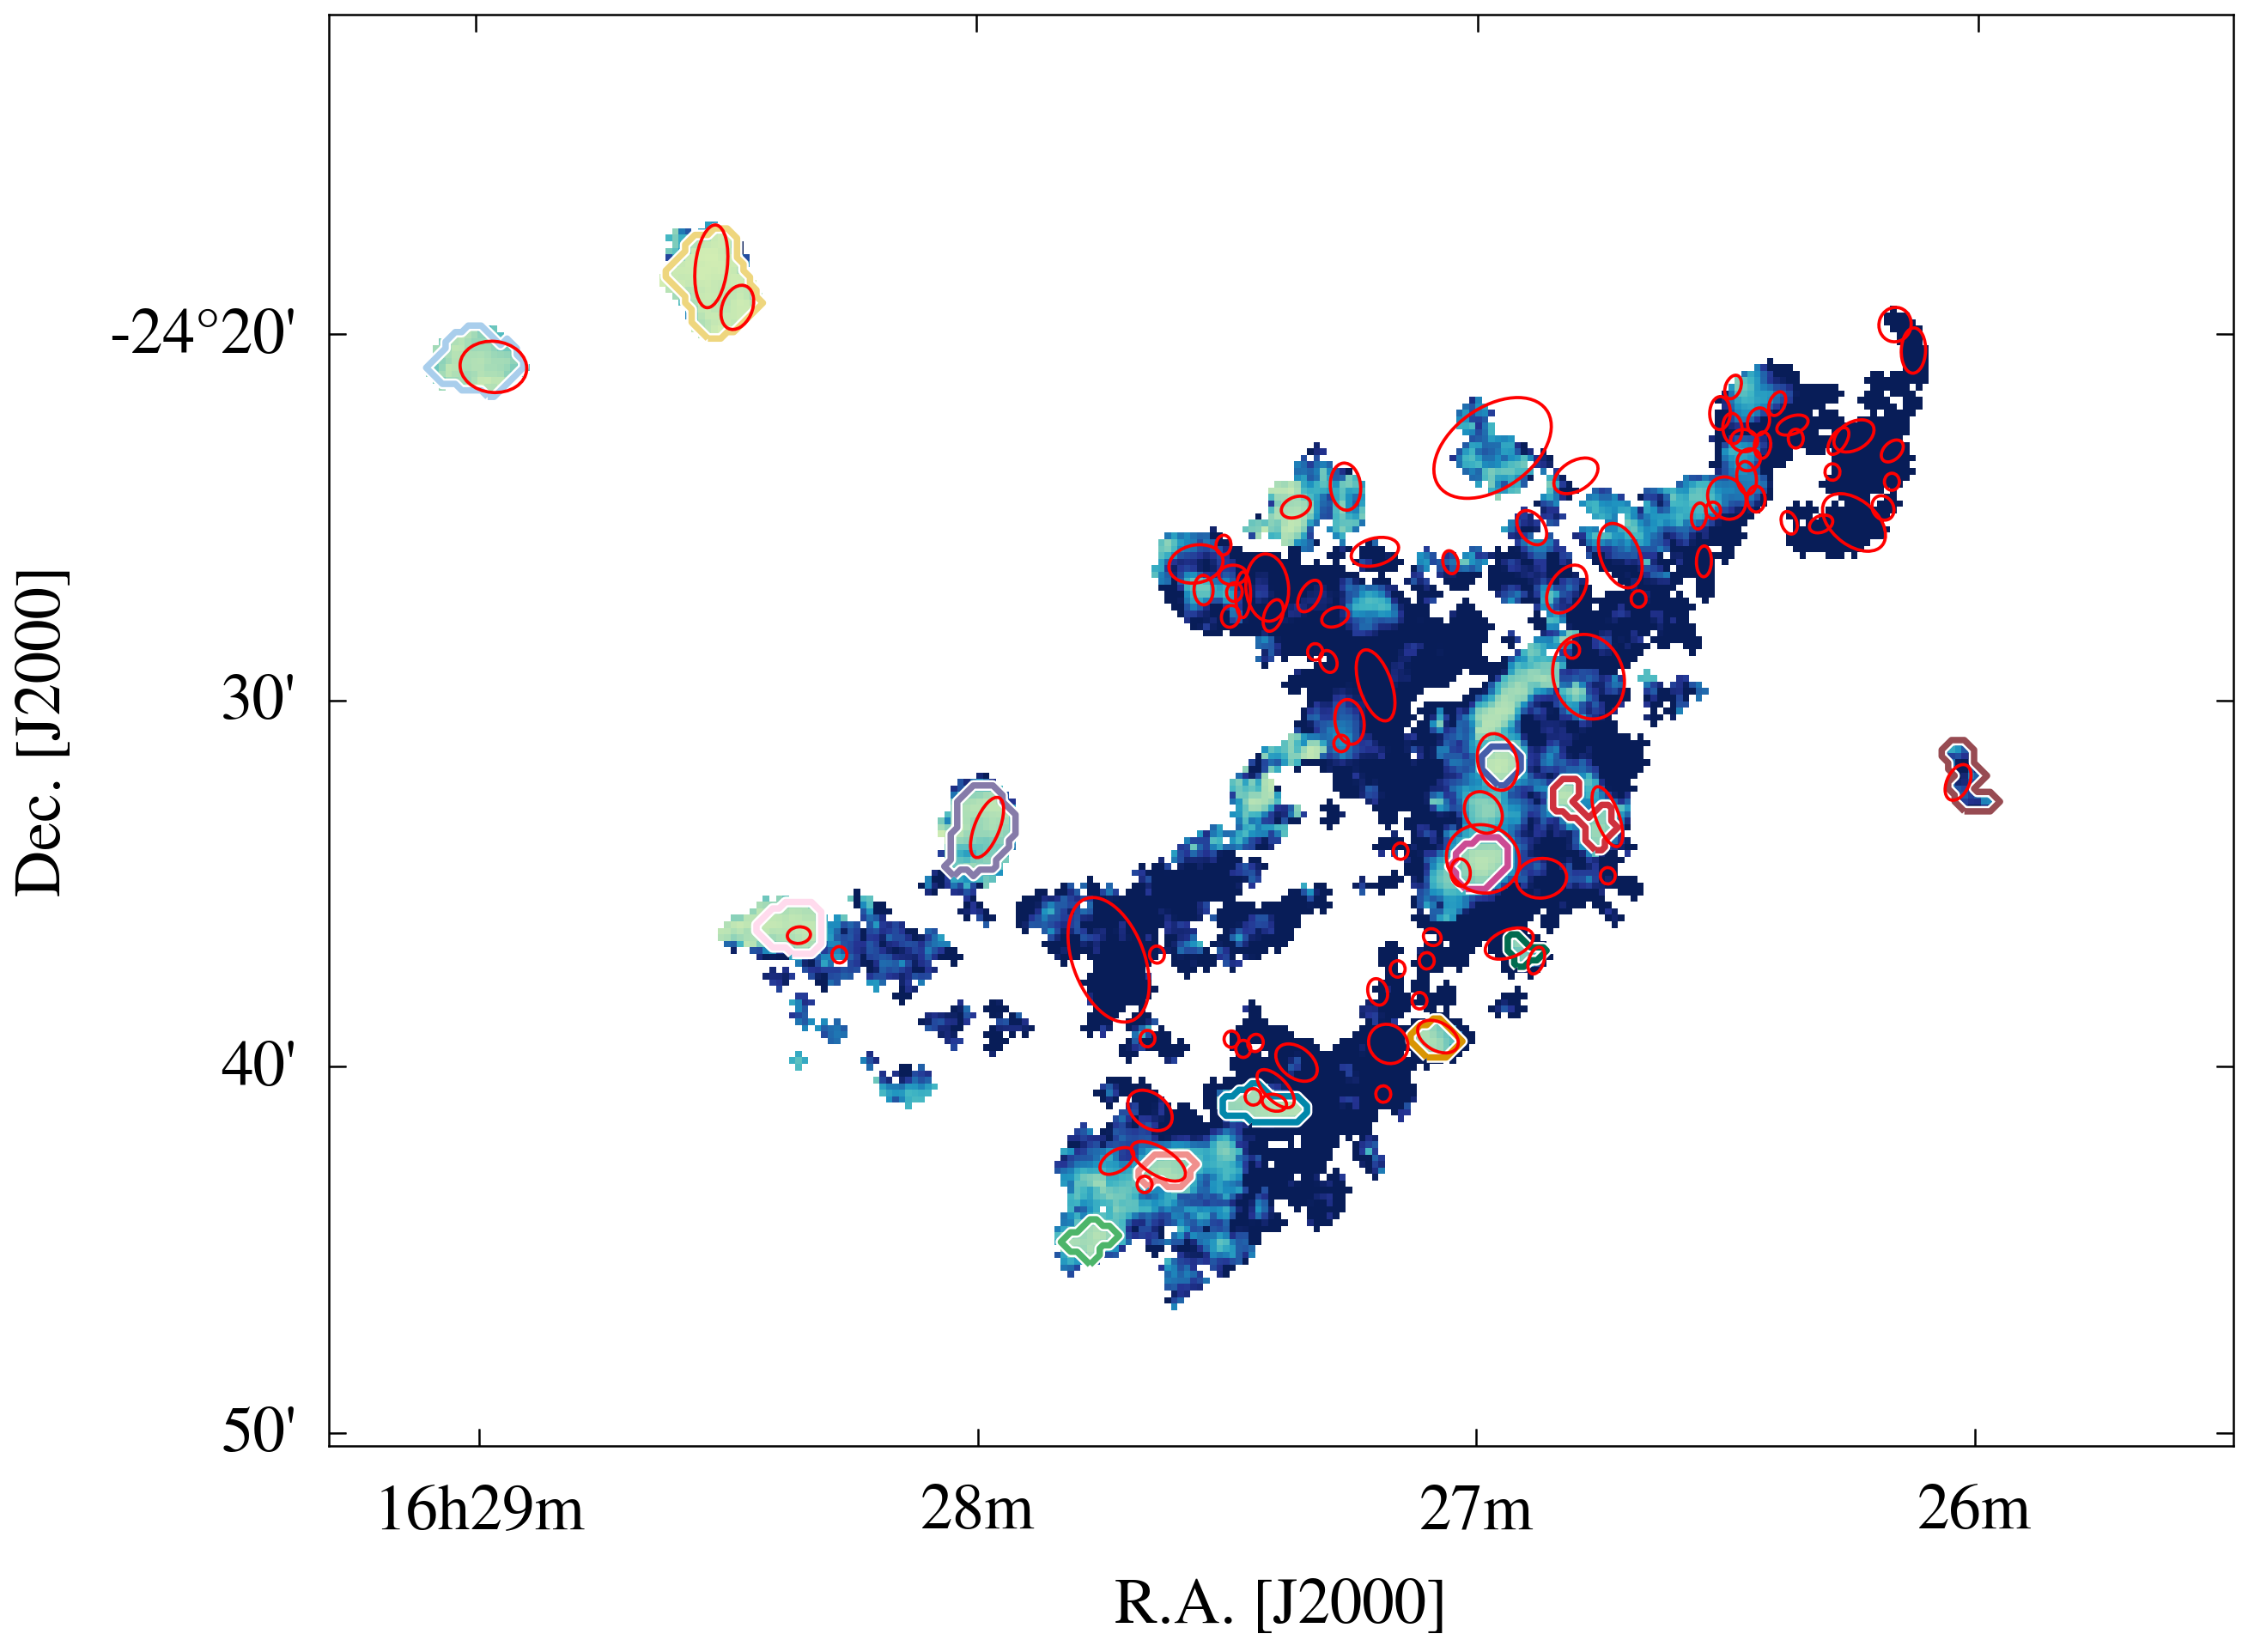

In [251]:
reg = 'L1688'
wcs_GAS = wcs.WCS(dict_data[reg]['header_GAS'])
pixscale = np.median(testTable['EFFRADIUS(pc)'].values/np.sqrt(testTable['S1'].values*testTable['S2'].values))

fig = plt.figure()
ax = fig.gca(projection = wcs_GAS)

ax.imshow(dict_data[reg]['Sigma'],
          cmap = 'YlGnBu',
          norm = colors.Normalize(0., .4))


xmesh, ymesh = np.meshgrid(np.arange(dict_data[reg]['Sigma'].shape[1]),
                           np.arange(dict_data[reg]['Sigma'].shape[0]))

for i, structure in enumerate(list(range(1, 13))+['extra']):
    
    ax.contour(dict_masks[reg][structure],
               levels = [.5],
               colors = 'w',
               linewidths = 5.)
    
    ax.contour(dict_masks[reg][structure],
               levels = [.5],
               colors = ssk_colors[i],
               linewidths = 3.)
    
    
SigmaMap, TkinMap = [], []
for i in range(len(testTable)):
    raStr, decStr = testTable[['RA', 'DEC']].loc[i].values
    icoord = SkyCoord(raStr, decStr,
                      unit=(u.hourangle, u.deg))
    ra, dec = icoord.ra.value, icoord.dec.value
    
    beam_center = (ra * u.deg, dec * u.deg)
    '''
    beam_size = (testTable[['EFFRADIUS(pc)']].loc[i].values[0]*u.pc/distances['L1688']).decompose().value
    beam_size = np.degrees(beam_size) * u.deg
    beam = wcsaxes.SphericalCircle(beam_center,
                                   beam_size,
                                   edgecolor = 'r',
                                   facecolor = 'none',
                                   linewidth = 2.,
                                   zorder = 999,
                                   transform = ax.get_transform('fk5'))
    '''
    beam_width = (testTable[['S1']].loc[i].values[0]*pixscale*u.pc/distances['L1688']).decompose().value
    beam_width = 2.*np.degrees(beam_width) * u.deg
    beam_height = (testTable[['S2']].loc[i].values[0]*pixscale*u.pc/distances['L1688']).decompose().value
    beam_height = 2.*np.degrees(beam_height) * u.deg
    beam_angle = testTable[['ANGLE']].loc[i].values[0] + 90.
    beam = patches.Ellipse((beam_center[0].value, beam_center[1].value),
                           beam_width.value, beam_height.value,
                           angle = beam_angle,
                           edgecolor = 'r',
                           facecolor = 'none',
                           linewidth = 1.5,
                           zorder = 999,
                           transform = ax.get_transform('fk5'))
    ax.add_patch(beam)
    
    # in pix system
    raPix, decPix = wcs_GAS.wcs_world2pix([[ra, dec]], 0)[0]
    s1Pix = beam_width.value/2./abs(dict_data[reg]['header_GAS']['CDELT1'])
    s2Pix = beam_height.value/2./abs(dict_data[reg]['header_GAS']['CDELT1'])
    angleRad = -np.radians(beam_angle)
    A = s1Pix**2.*np.sin(angleRad)**2.+s2Pix**2.*np.cos(angleRad)**2.
    B = 2.*(s2Pix**2.-s1Pix**2.)*np.sin(angleRad)*np.cos(angleRad)
    C = s1Pix**2.*np.cos(angleRad)**2.+s2Pix**2.*np.sin(angleRad)**2.
    D = -2.*A*raPix - B*decPix
    E = -B*raPix - 2.*C*decPix
    F = A*raPix**2. + B*raPix*decPix + C*decPix**2. - s1Pix**2.*s2Pix**2.
    
    beamMask = ((A*xmesh**2.+B*xmesh*ymesh+C*ymesh**2.+D*xmesh+E*ymesh+F) < 0.)
    
    '''
    ax.contour(beamMask,
               levels = [.5],
               colors = 'r',
               linewidths = 2.,
               zorder = 1000)
    '''
    
    SigmaMap.append(np.nanmedian(dict_data[reg]['Sigma'][beamMask]))
    TkinMap.append(np.nanmedian(dict_data[reg]['Tkin'][beamMask]))
    
testDerived['SigmaMap'] = SigmaMap
testDerived['TkinMap'] = TkinMap

testDerived['SigmaTMap'] = np.sqrt(c.k_B*testDerived['TkinMap'].values*u.K/mass['average']).to(u.km/u.s).value
testDerived['SigmaNTMap'] = np.sqrt((testDerived['SigmaMap'].values*u.km/u.s)**2.
                                    -c.k_B*testDerived['TkinMap'].values*u.K/mass['NH3']).to(u.km/u.s).value
testDerived['SigmaTotMap'] = np.sqrt(testDerived['SigmaTMap']**2. + testDerived['SigmaNTMap']**2.)


ax.coords[0].set_major_formatter('hh:mm')
ax.coords[0].set_axislabel('R.A. [J2000]')
ax.coords[1].set_major_formatter('dd:mm')
ax.coords[1].set_axislabel('Dec. [J2000]')

direcComparison = '/Users/hopechen/Documents/projects/git_projects/Droplets/tests/comparison_Kirk/'
plt.savefig(direcComparison+'skyMap.png')

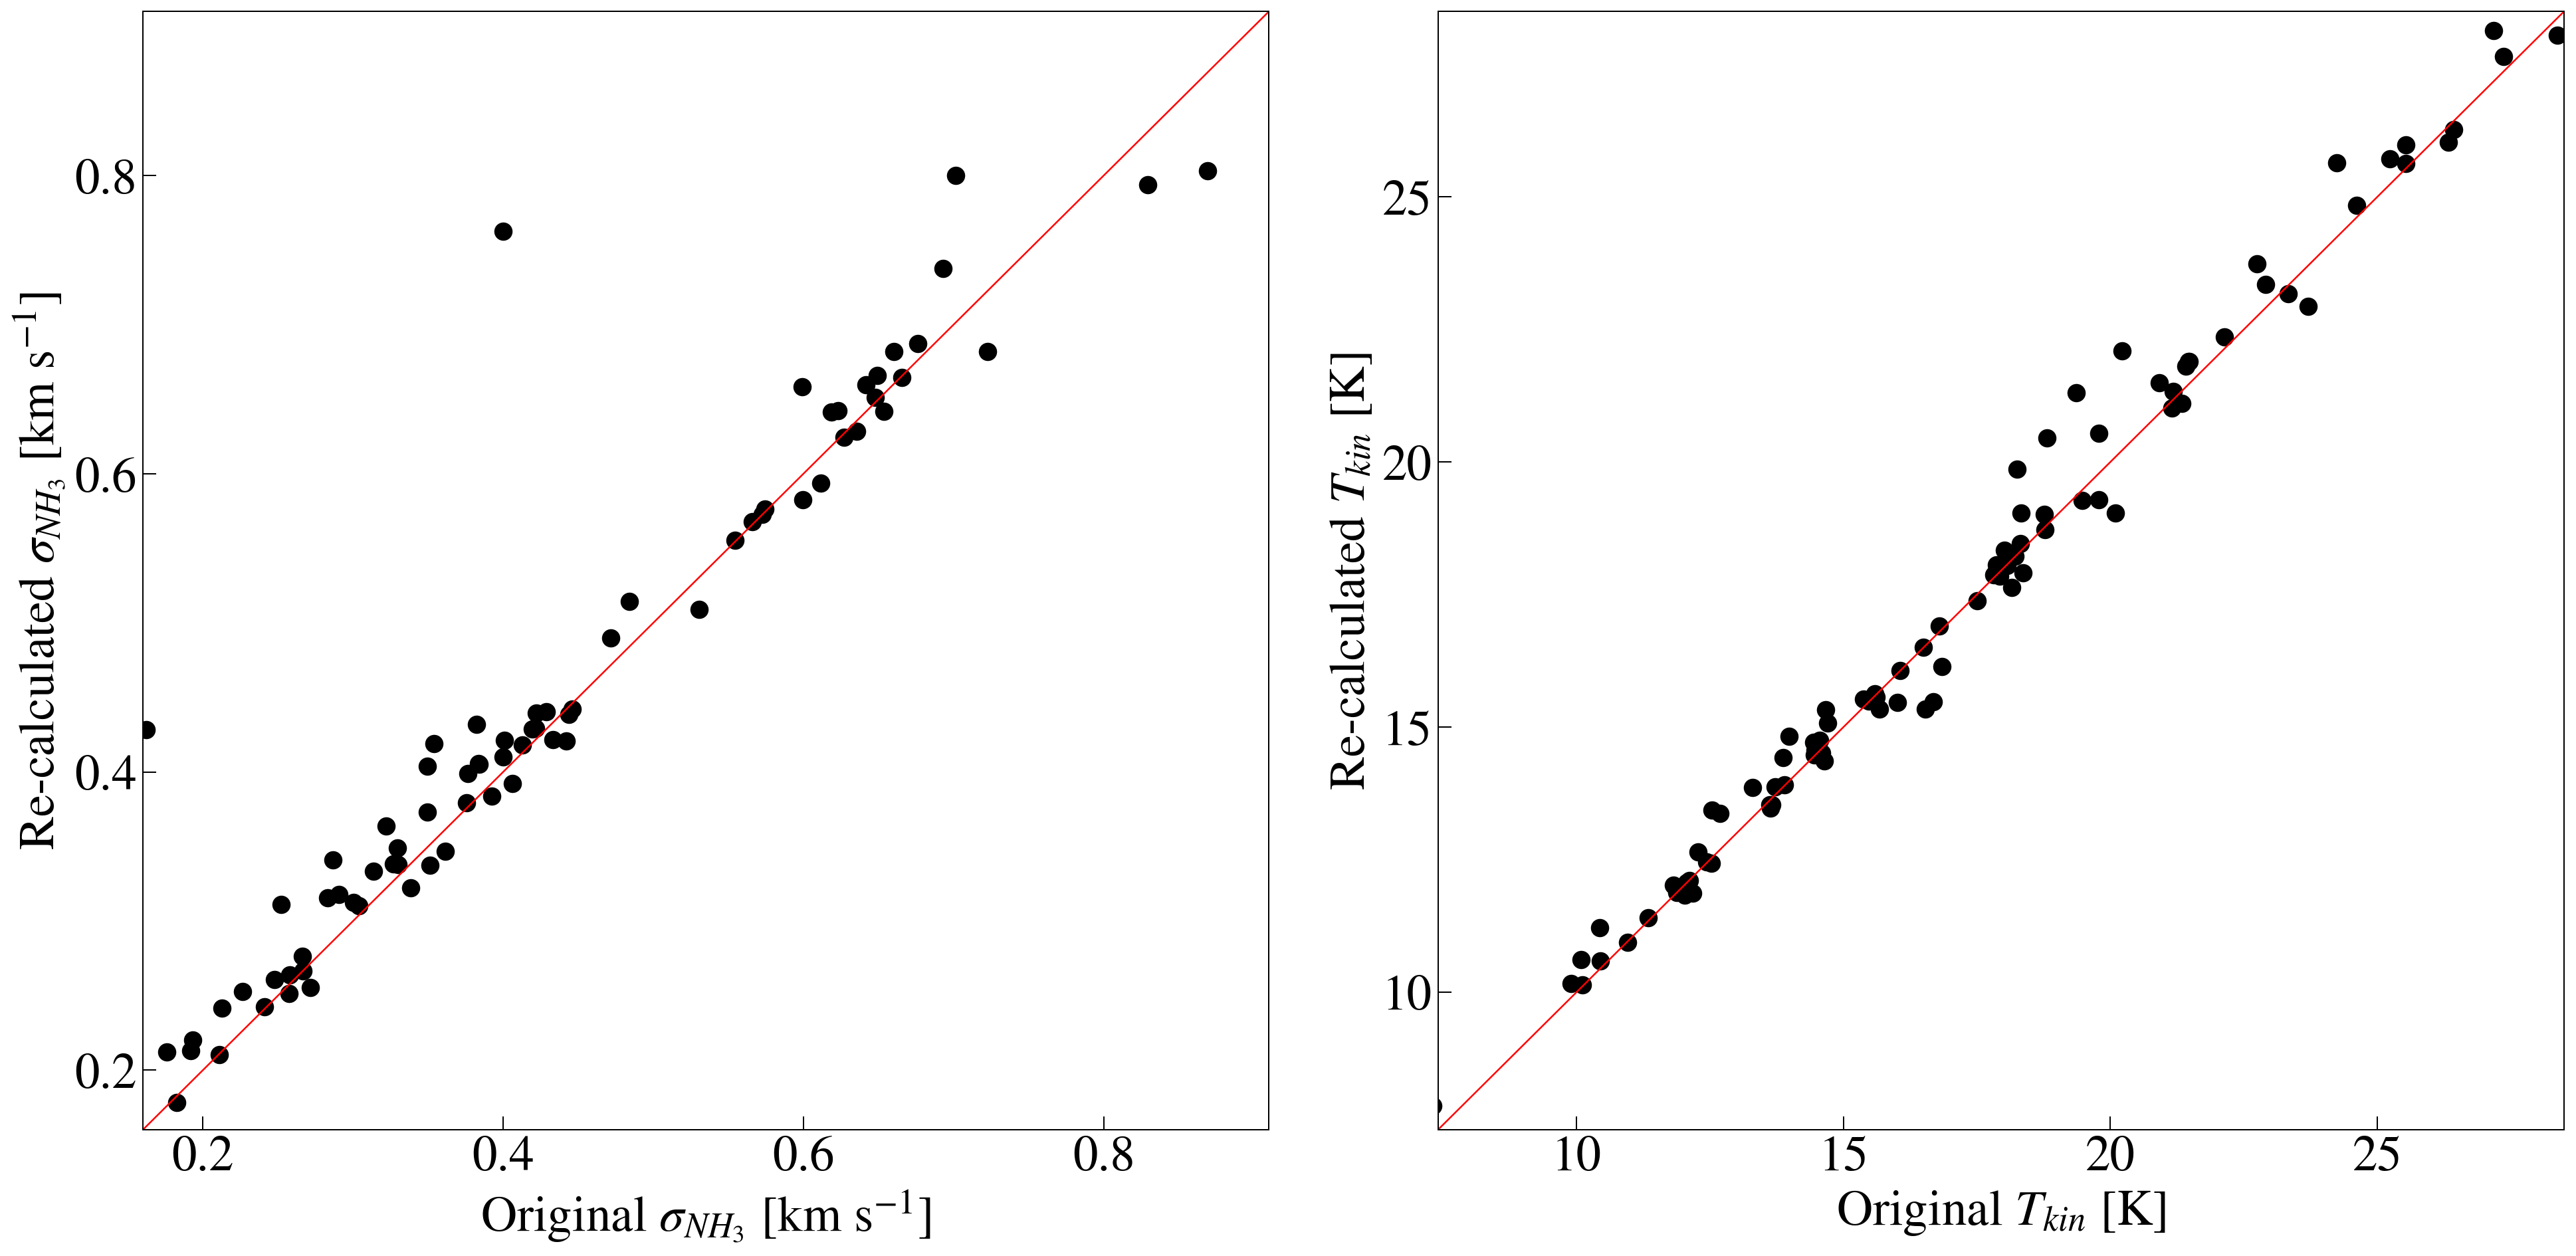

In [255]:
rcParams['figure.subplot.wspace'] = .15
rcParams['figure.subplot.bottom'] = .13
rcParams['figure.subplot.top'] = .98

fig, axes = plt.subplots(figsize = (23., 11.),
                         ncols = 2)

ax = axes[0]
ax.plot(testDerived['Sigma'], testDerived['SigmaMap'],
         'k.')

ax.plot([0., 1.], [0., 1.],
         'r-')

ax.set_xlim(.16, .91)
ax.set_ylim(.16, .91)
ax.set_yticks([.2, .4, .6, .8])
ax.set_xlabel('Original $\sigma_{NH_3}$ [km s$^{-1}$]')
ax.set_ylabel('Re-calculated $\sigma_{NH_3}$ [km s$^{-1}$]')


ax = axes[1]
ax.plot(testDerived['Tkin'], testDerived['TkinMap'],
         'k.')

ax.plot([0., 30.], [0., 30.],
         'r-')

ax.set_xlim(7.4, 28.5)
ax.set_ylim(7.4, 28.5)
ax.set_yticks([10., 15., 20., 25.])
ax.set_xlabel('Original $T_{kin}$ [K]')
ax.set_ylabel('Re-calculated $T_{kin}$ [K]')

direcComparison = '/Users/hopechen/Documents/projects/git_projects/Droplets/tests/comparison_Kirk/'
plt.savefig(direcComparison+'recalculation.png')

In [239]:
direcFinal = '/Users/hopechen/Documents/projects/GAS/projects/GASAng_final/'
d_table = pd.DataFrame.from_csv(direcFinal+'table_full.csv')

direcProject = '/Users/hopechen/Documents/projects/GAS/projects/GASAng/'
d_AG = pd.DataFrame.from_csv(direcProject+'Goodman93.csv')

## pixscales
d_pixscale = {}
for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        distance = 137.3
    elif reg == 'B18':
        distance = 135.
    
    hdr = dict_data[reg]['header_GAS']
    d_pixscale[reg] = (abs(hdr['CDELT1'])*3600.*distance*u.AU).to(u.pc).value

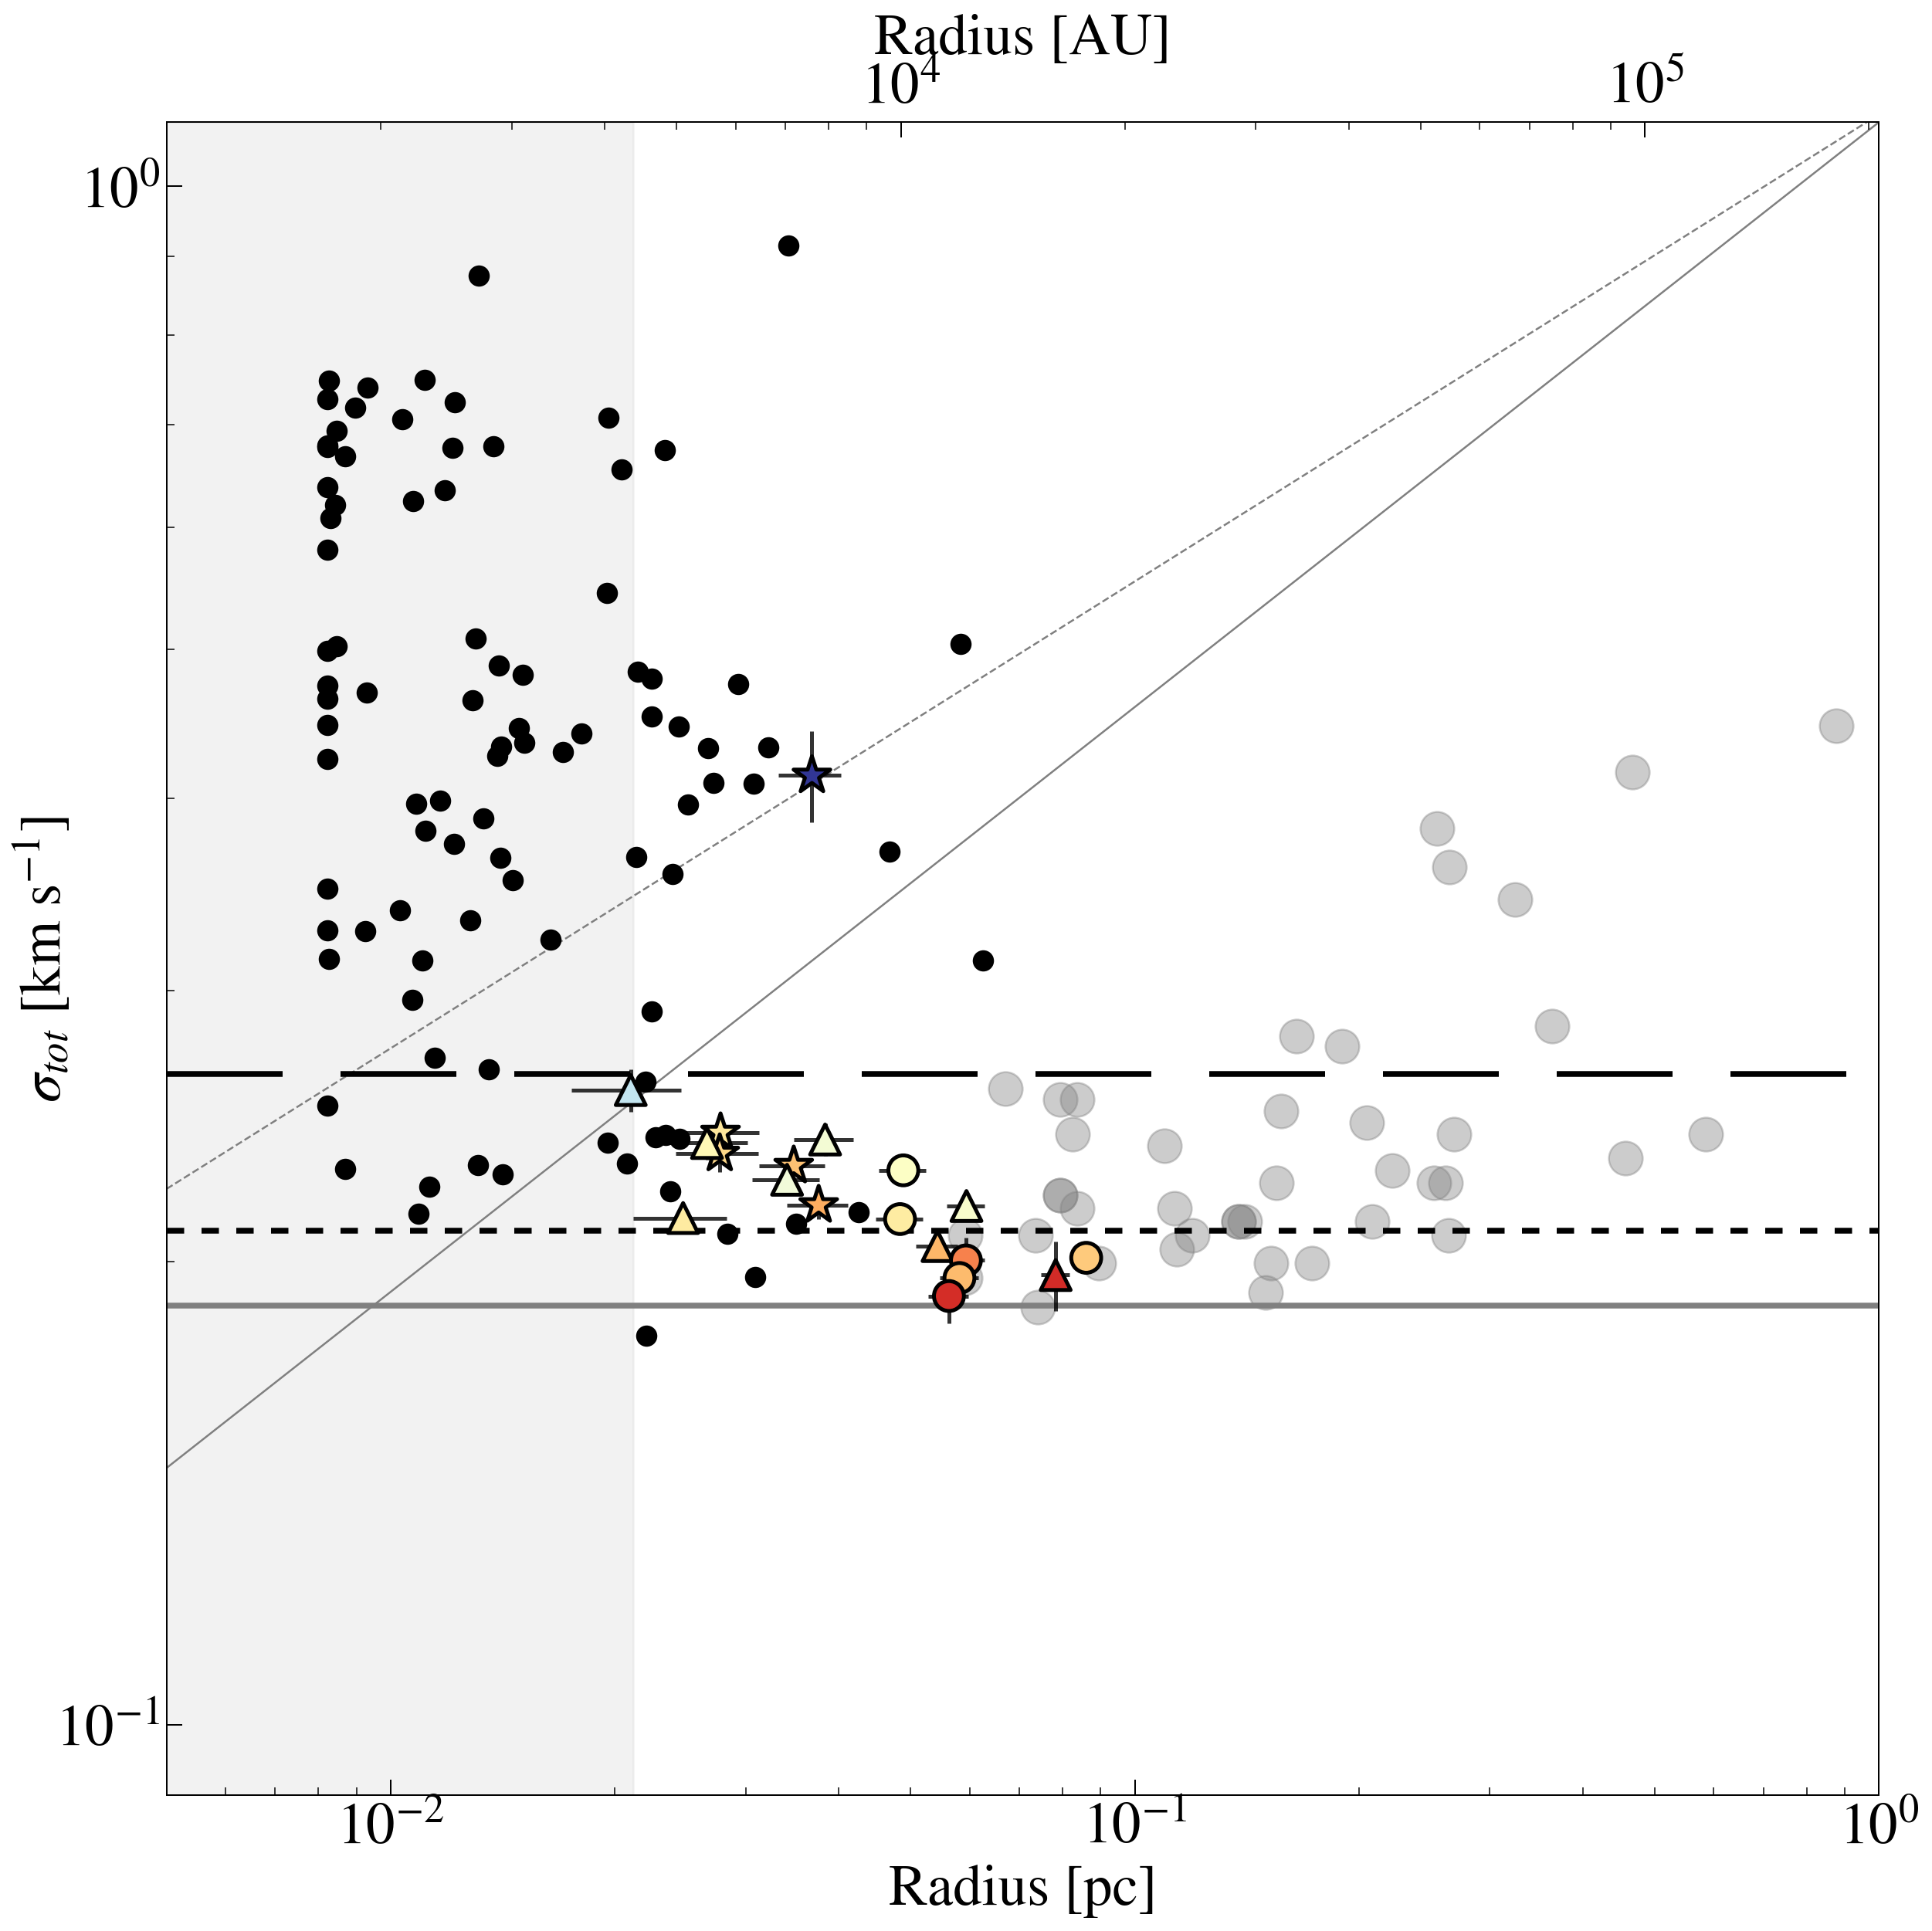

In [253]:
###
rcParams['figure.subplot.left'] = .09
rcParams['figure.subplot.right'] = .97
rcParams['figure.subplot.bottom'] = .07
rcParams['figure.subplot.top'] = .93
rcParams['font.size'] = 30
pixscale = d_pixscale['L1688']
###

# prepare
xx, yy = d_table['Radius'].values, d_table['Vdisp_total'].values
xerr, yerr = d_table['Radius_ERR'].values, d_table['Vdisp_total_ERR'].values
## color coded by the ratio of the thermal support to the total kinetic energy.
ccode = d_table['Vdisp_T'].values**2./d_table['Vdisp_total'].values**2.
## AG
xAG, yAG = (d_AG['radius'].values*u.AU).to(u.pc).value, d_AG['sigmaV']
## limits
xmin, xmax = 5e-3, 1e0
ymin, ymax = 9e-2, 1.1e0
## expected vel dispersion
#NT10K1 = (np.sqrt(c.k_B*10.*u.K/(17.031*u.u)+c.k_B*10.*u.K/(2.37*u.u))).to(u.km/u.s).value
#NT10K2 = (np.sqrt((c.k_B*10.*u.K/(17.031*u.u)+.5**2.*c.k_B*10.*u.K/(2.37*u.u)))).to(u.km/u.s).value
## sig total
NT10K1 = (np.sqrt(2.*c.k_B*10.*u.K/(2.37*u.u))).to(u.km/u.s).value
NT10K2 = (np.sqrt((.5**2.+1.)*c.k_B*10.*u.K/(2.37*u.u))).to(u.km/u.s).value

Thermal = (np.sqrt(c.k_B*10.*u.K/(2.37*u.u))).to(u.km/u.s).value

fig = plt.figure(figsize = (14., 14.))
ax = fig.gca()


for QA in set(d_table['QA']):
    for stars in set(d_table['protostars']):
        
        xxP, yyP = xx[((d_table['QA'] == QA)&(d_table['protostars'] == stars)).values],\
                   yy[((d_table['QA'] == QA)&(d_table['protostars'] == stars)).values]
        ccodeP = ccode[((d_table['QA'] == QA)&(d_table['protostars'] == stars)).values]
        xerrP = xerr[((d_table['QA'] == QA)&(d_table['protostars'] == stars)).values]
        yerrP = yerr[((d_table['QA'] == QA)&(d_table['protostars'] == stars)).values]
        
        
        size = 240.
        if stars == 'inside':
            marker = '*'
            size = 400.
        elif stars == 'nearby':
            marker = '^'
        elif stars == 'no':
            marker = 'o'
            
            
        ax.scatter(xxP, yyP,
                   c = ccodeP,
                   cmap = 'RdYlBu_r',
                   marker = marker,
                   norm = colors.Normalize(vmin = .5, vmax = 1.),
                   s = size,
                   edgecolors = 'k',
                   linewidth = 2.,
                   zorder = 100)

        ax.errorbar(xxP, yyP, xerr = xerrP, yerr = yerrP,
                    linestyle = 'none',
                    linewidth = 2.,
                    color = 'k',
                    alpha = .8,
                    zorder = 99)


# plot
#ax.scatter(xx, yy,
#           c = ccode,
#           cmap = 'RdYlBu_r',
#           norm = colors.Normalize(vmin = .5, vmax = 1.),
#           s = 240.,
#           edgecolors = 'k',
#           linewidth = .5,
#           zorder = 100)

#ax.errorbar(xx, yy, xerr = xerr, yerr = yerr,
#            linestyle = 'none',
#            linewidth = 2.,
#            color = 'k',
#            alpha = .8,
#            zorder = 99)
## AG
ax.plot(xAG, yAG,
        linestyle = 'none',
        marker = '.',
        color = 'gray',
        markersize = 35.,
        alpha = .4,
        zorder = 2)

## beam
ax.fill_between([ax.get_xlim()[0], 3.*pixscale], 2*[ymin], 2*[ymax],
                color = 'gray',
                alpha = .1,
                edgecolor = 'none',
                zorder = 0)


## larson SigmaCO
ax.plot([xmin, xmax], 1.1*np.array([xmin, xmax])**.38,
        color = 'gray',
        linestyle = '-',
        linewidth = 1.,
        zorder = 1)
## larson SigmaTot assuming 10K
ax.plot([xmin, xmax],
        np.sqrt((1.1*np.array([xmin, xmax])**.38*u.km/u.s)**2.
                -c.k_B*10.*u.K/(12.*u.u)
                +c.k_B*10.*u.K/mass['average']).to(u.km/u.s).value,
        color = 'gray',
        linestyle = '--',
        linewidth = 1.,
        zorder = 1)

### Plot the expected line widths
ax.plot([xmin, xmax], [NT10K1]*2,
        color = 'k',
        linestyle = '--',
        linewidth = 3.,
        dashes = (20., 10.))
ax.plot([xmin, xmax], [NT10K2]*2,
        color = 'k',
        linestyle = ':',
        linewidth = 3.,
        dashes = (3., 3.))
ax.plot([xmin, xmax], [Thermal]*2,
        color = 'gray',
        linestyle = '-',
        linewidth = 3.)

## Ronan and Helen's work
ax.plot(testDerived['Reff'], testDerived['SigmaTot'],
        'k.')

# adjust the plot
ax.set_xlabel('Radius [pc]')
ax.set_ylabel(r'$\sigma_{tot}$ [km s$^{-1}$]',
              labelpad = -10.)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xscale('log')
ax.set_yscale('log')


axtw = ax.twiny()
axtw.set_xlim(*(ax.get_xlim()*u.pc).to(u.AU).value)
axtw.set_xscale('log')
axtw.set_xlabel('Radius [AU]')


direcComparison = '/Users/hopechen/Documents/projects/git_projects/Droplets/tests/comparison_Kirk/'
plt.savefig(direcComparison+'comparison.png')

In [ ]:
beam_center = tuple(wcs_GAS.wcs_pix2world([[frame[0]+1./6.*frame[2], frame[1]+1./6.*frame[3]]], 0)[0]*u.deg)
        beam_size = header['BMAJ']/2. * u.degree
        beam = wcsaxes.SphericalCircle(beam_center,
                                       beam_size,
                                       edgecolor = 'w',
                                       facecolor = 'k',
                                       linewidth = 2.,
                                       zorder = 999,
                                       transform = axis.get_transform('fk5'))
        axis.add_patch(beam)